# 🚜 Bulldozer Price Prediction

The **goal of this project** was to predict the sale price of bulldozers.

The **data** is from a Kaggle competition: https://www.kaggle.com/c/bluebook-for-bulldozers/

As normal in Kaggle competitions the target of the test set isn't publicy availabe. To get a performance metric for the model in this project I therefore didn't use the actual test set, but rather used a part of the train and validation set as test data. With over 400'000 instances this didn't pose a problem.

* The training set used in this project consists of instances sold from 1989 to the middle of 2010.
* The validation set contains instances sold from the middle to the end of 2010.
* The test set contains instances sold from 2011 to April 2012.

**Evaluation metrics** used were mean absolute error, root mean squared error and r2 score.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
!pip install lightgbm
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings("ignore")

!pip install mrmr_selection
from mrmr import mrmr_classif

!pip install category_encoders
import category_encoders as ce
from pandas.api.types import is_categorical_dtype, is_string_dtype

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 3.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Load Data and Basic Exploration

In [3]:
df = pd.read_csv("drive/MyDrive/bulldozer_project/bulldozer-project/bulldozer_data/TrainAndValid.csv",
                 low_memory=False,
                 parse_dates=["saledate"])
pd.set_option("display.max_columns", None)

In [4]:
df = df.sort_values(by=["saledate"], ascending=True)

In [5]:
# Create new time features
df["saleYear"] = df["saledate"].dt.year
df["saleMonth"] = df["saledate"].dt.month
df["saleDay"] = df["saledate"].dt.day
df["saleDayOfYear"] = df["saledate"].dt.dayofyear
df["saleDayOfWeek"] = df["saledate"].dt.dayofweek
del df["saledate"]

df_train = df[df["saleYear"]<2011]
df_test = df[df["saleYear"]>=2011]

In [6]:
df_train.shape

(365928, 57)

In [7]:
df_train.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay,saleDayOfYear,saleDayOfWeek
205615,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,TD20,TD20,NaN,NaN,NaN,Medium,"Track Type Tractor, Dozer - 105.0 to 130.0 Hor...",Texas,TTT,Track Type Tractors,NaN,OROPS,NaN,NaN,NaN,NaN,Direct Drive,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,17,17,1
274835,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,A66,A66,NaN,NaN,NaN,NaN,Wheel Loader - 120.0 to 135.0 Horsepower,Florida,WL,Wheel Loader,NaN,OROPS,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional,1989,1,31,31,1
141296,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,D7G,D7,G,NaN,NaN,Large,"Track Type Tractor, Dozer - 190.0 to 260.0 Hor...",Florida,TTT,Track Type Tractors,NaN,OROPS,NaN,NaN,NaN,NaN,Standard,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,31,31,1
212552,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,A62,A62,NaN,NaN,NaN,NaN,Wheel Loader - Unidentified,Florida,WL,Wheel Loader,NaN,EROPS,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional,1989,1,31,31,1
62755,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,D3B,D3,B,NaN,NaN,NaN,"Track Type Tractor, Dozer - 20.0 to 75.0 Horse...",Florida,TTT,Track Type Tractors,NaN,OROPS,NaN,NaN,NaN,NaN,Standard,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,Lever,NaN,NaN,1989,1,31,31,1


In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 365928 entries, 205615 to 20313
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   365928 non-null  int64  
 1   SalePrice                 365928 non-null  float64
 2   MachineID                 365928 non-null  int64  
 3   ModelID                   365928 non-null  int64  
 4   datasource                365928 non-null  int64  
 5   auctioneerID              345792 non-null  float64
 6   YearMade                  365928 non-null  int64  
 7   MachineHoursCurrentMeter  120280 non-null  float64
 8   UsageBand                 52527 non-null   object 
 9   fiModelDesc               365928 non-null  object 
 10  fiBaseModel               365928 non-null  object 
 11  fiSecondaryDesc           238877 non-null  object 
 12  fiModelSeries             51392 non-null   object 
 13  fiModelDescriptor         62609 non-null

In [9]:
df_train.describe()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleDay,saleDayOfYear,saleDayOfWeek
count,3.659280e+05,365928.000000,3.659280e+05,365928.000000,365928.000000,345792.000000,365928.000000,1.202800e+05,365928.000000,365928.000000,365928.000000,365928.000000,365928.000000
mean,1.769439e+06,30830.913013,1.197766e+06,6722.048321,133.526385,6.567058,1896.774647,3.239153e+03,2003.431637,6.408589,16.047362,179.982939,2.625435
std,5.475954e+05,22835.041483,4.148507e+05,6036.391228,7.041611,16.718941,294.170934,2.995679e+04,5.591904,3.422982,8.430149,103.531762,1.415506
min,1.139246e+06,4750.000000,0.000000e+00,28.000000,121.000000,0.000000,1000.000000,0.000000e+00,1989.000000,1.000000,1.000000,2.000000,0.000000
25%,1.413369e+06,14500.000000,1.092230e+06,3257.000000,132.000000,1.000000,1984.000000,0.000000e+00,2000.000000,3.000000,9.000000,84.000000,2.000000
50%,1.627822e+06,24000.000000,1.273301e+06,4604.000000,132.000000,2.000000,1994.000000,0.000000e+00,2005.000000,6.000000,16.000000,168.000000,3.000000
75%,2.196875e+06,39500.000000,1.451946e+06,8426.000000,136.000000,4.000000,2000.000000,2.258000e+03,2008.000000,9.000000,23.000000,271.000000,3.000000
max,4.512895e+06,142000.000000,2.386738e+06,37198.000000,172.000000,99.000000,2012.000000,2.483300e+06,2010.000000,12.000000,31.000000,365.000000,6.000000


In [10]:
basic_infos = pd.DataFrame()
basic_infos["NAs"] = df_train.isna().sum()
basic_infos["NA ratio"] = round(df_train.isna().sum() / len(df) * 100, 4)
basic_infos["dtype"] = df_train.dtypes

In [11]:
basic_infos

,NAs,NA ratio,dtype
SalesID,0,0.0000,int64
SalePrice,0,0.0000,float64
MachineID,0,0.0000,int64
ModelID,0,0.0000,int64
datasource,0,0.0000,int64
auctioneerID,20136,4.8791,float64
YearMade,0,0.0000,int64
MachineHoursCurrentMeter,245648,59.5225,float64
UsageBand,313401,75.9395,object
fiModelDesc,0,0.0000,object


Most of the categorical features have a very high missing values ratio. 70% + missing values per feature are very common.

# Baseline Model

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [12]:
val_idx = df_train[(df_train["saleYear"]==2010)&(df_train["saleDayOfYear"]>365/2)].index
X_train, y_train = df_train.drop(val_idx).drop("SalePrice", axis=1), df_train.drop(val_idx)["SalePrice"]
X_val, y_val = df_train.loc[val_idx, :].drop("SalePrice", axis=1) ,df_train.loc[val_idx, :]["SalePrice"]

features = ["SalesID", "MachineID", "ModelID", "datasource", "YearMade", "auctioneerID", 
            "MachineHoursCurrentMeter", "ProductGroup"]

In [13]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((351453, 56), (351453,), (14475, 56), (14475,))

In [ ]:
# OneHotEncoding Transformer
oh_encoder = ce.OneHotEncoder(cols=["ProductGroup"])
X_train_prepared = oh_encoder.fit_transform(X_train[features])
X_val_prepared = oh_encoder.transform(X_val[features])
X_train_prepared = X_train_prepared.fillna(0)
X_val_prepared = X_val_prepared.fillna(0)

In [ ]:
X_train_prepared.shape, X_val_prepared.shape

((351453, 13), (14475, 13))

In [84]:
def show_metrics(X_train, y_train, X_val, y_val, model):
  train_preds = model.predict(X_train)
  val_preds = model.predict(X_val)
  scores = {"Training MAE": mean_absolute_error(y_train, train_preds),
            "Valid MAE": mean_absolute_error(y_val, val_preds),
            "Training RMSE": mean_squared_error(y_train, train_preds, squared=False),
            "Valid RMSE": mean_squared_error(y_val, val_preds, squared=False),
            "Training R^2": r2_score(y_train, train_preds),
            "Valid R^2": r2_score(y_val, val_preds)}
  return scores, val_preds

In [ ]:
# RandomForest
rf_reg = RandomForestRegressor(n_estimators=50, max_samples=100000)
rf_reg.fit(X_train_prepared, y_train)

# XGBoost
xgb_reg = XGBRegressor()
xgb_reg.fit(X_train_prepared, y_train)

# LGBM
lgbm_reg = LGBMRegressor()
lgbm_reg.fit(X_train_prepared, y_train)

# HistGradientBoostingRegressor
hgbr = HistGradientBoostingRegressor()
hgbr.fit(X_train_prepared, y_train)

[11:45:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


LGBMRegressor()

In [ ]:
scores_rf, val_preds_rf = show_metrics(X_train_prepared, y_train, X_val_prepared, y_val, rf_reg)
scores_xgb, val_preds_xgb = show_metrics(X_train_prepared, y_train, X_val_prepared, y_val, xgb_reg)
scores_lgbm, val_preds_lgbm = show_metrics(X_train_prepared, y_train, X_val_prepared, y_val, lgbm_reg)
scores_hgbr, val_preds_hgbr = show_metrics(X_train_prepared, y_train, X_val_prepared, y_val, hgbr)

In [ ]:
# RandomForest with best results on validation set
# BUT: other models all have a much smaller difference between training and validation scores -> more room to tune
print("RandomForest")
print(scores_rf)
print("")
print("XGBRegressor")
print(scores_xgb)
print("")
print("LGBMRegressor")
print(scores_lgbm)
print("")
print("HistGradientBoostingRegressor")
print(scores_hgbr)

RandomForest
{'Training MAE': 5128.8550417836805, 'Valid MAE': 7851.182429015544, 'Training RMSE': 7907.804139205661, 'Valid RMSE': 11542.234340918687, 'Training R^2': 0.879899077868997, 'Valid R^2': 0.7531992355063117}

XGBRegressor
{'Training MAE': 10060.213006221247, 'Valid MAE': 10577.589169213488, 'Training RMSE': 14625.606399830875, 'Valid RMSE': 14965.912102432552, 'Training R^2': 0.5891698606082711, 'Valid R^2': 0.585071652861199}

LGBMRegressor
{'Training MAE': 8254.49980299535, 'Valid MAE': 8818.240366113943, 'Training RMSE': 12201.002310332386, 'Valid RMSE': 12818.242278671098, 'Training R^2': 0.7140924971710205, 'Valid R^2': 0.6956146980414579}

HistGradientBoostingRegressor
{'Training MAE': 8208.082339567642, 'Valid MAE': 8843.69401514168, 'Training RMSE': 12149.467879721657, 'Valid RMSE': 12838.088381655221, 'Training R^2': 0.7165026210585048, 'Valid R^2': 0.6946714269811138}


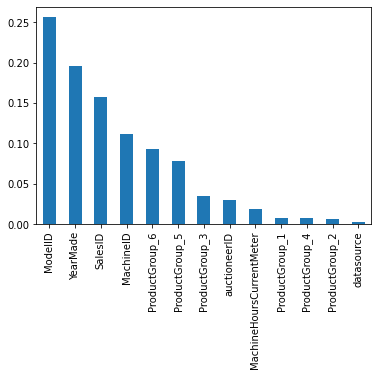

In [ ]:
feature_importances = pd.Series(rf_reg.feature_importances_, index=X_train_prepared.columns)
feature_importances.sort_values(ascending=False).plot.bar();

# Model Evaluation

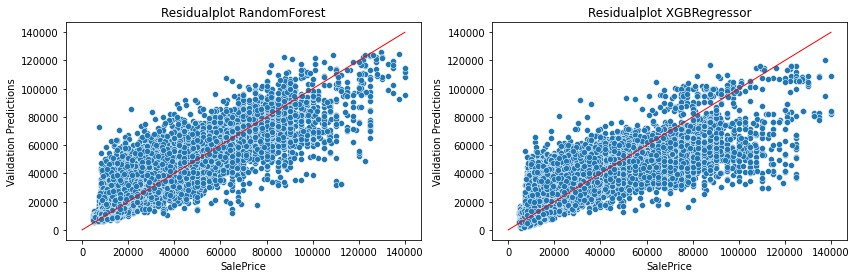

In [ ]:
fig, [ax0, ax1] = plt.subplots(1, 2, figsize=(14, 4))
sns.scatterplot(x=y_val, y=val_preds_rf, ax=ax0)
sns.lineplot(x=[0, 140000], y=[0, 140000], color="red", linewidth=1, ax=ax0)
ax0.set_title("Residualplot RandomForest")
ax0.set_ylabel("Validation Predictions")

sns.scatterplot(x=y_val, y=val_preds_xgb, ax=ax1)
sns.lineplot(x=[0, 140000], y=[0, 140000], color="red", linewidth=1, ax=ax1)
ax1.set_title("Residualplot XGBRegressor")
ax1.set_ylabel("Validation Predictions");

For low prices the models tend to predict too high prices, whereas for high prices they tend to predict too low prices. This tendency is even stronger for XGBoost for example.

In [ ]:
val_preds_rf = pd.Series(val_preds_rf, index=y_val.index, name="val_preds_rf")
val_preds_xgb = pd.Series(val_preds_xgb, index=y_val.index, name="val_preds_xgb")
val_preds_lgbm = pd.Series(val_preds_lgbm, index=y_val.index, name="val_preds_lgbm")
val_preds_hgbr = pd.Series(val_preds_hgbr, index=y_val.index, name="val_preds_hgbr")

In [ ]:
high_error_idx_rf = y_val[abs(y_val - val_preds_rf) > 20000].index
high_error_idx_xgb = y_val[abs(y_val - val_preds_xgb) > 20000].index
high_error_idx_lgbm = y_val[abs(y_val - val_preds_lgbm) > 20000].index
high_error_idx_hgbr = y_val[abs(y_val - val_preds_hgbr) > 20000].index

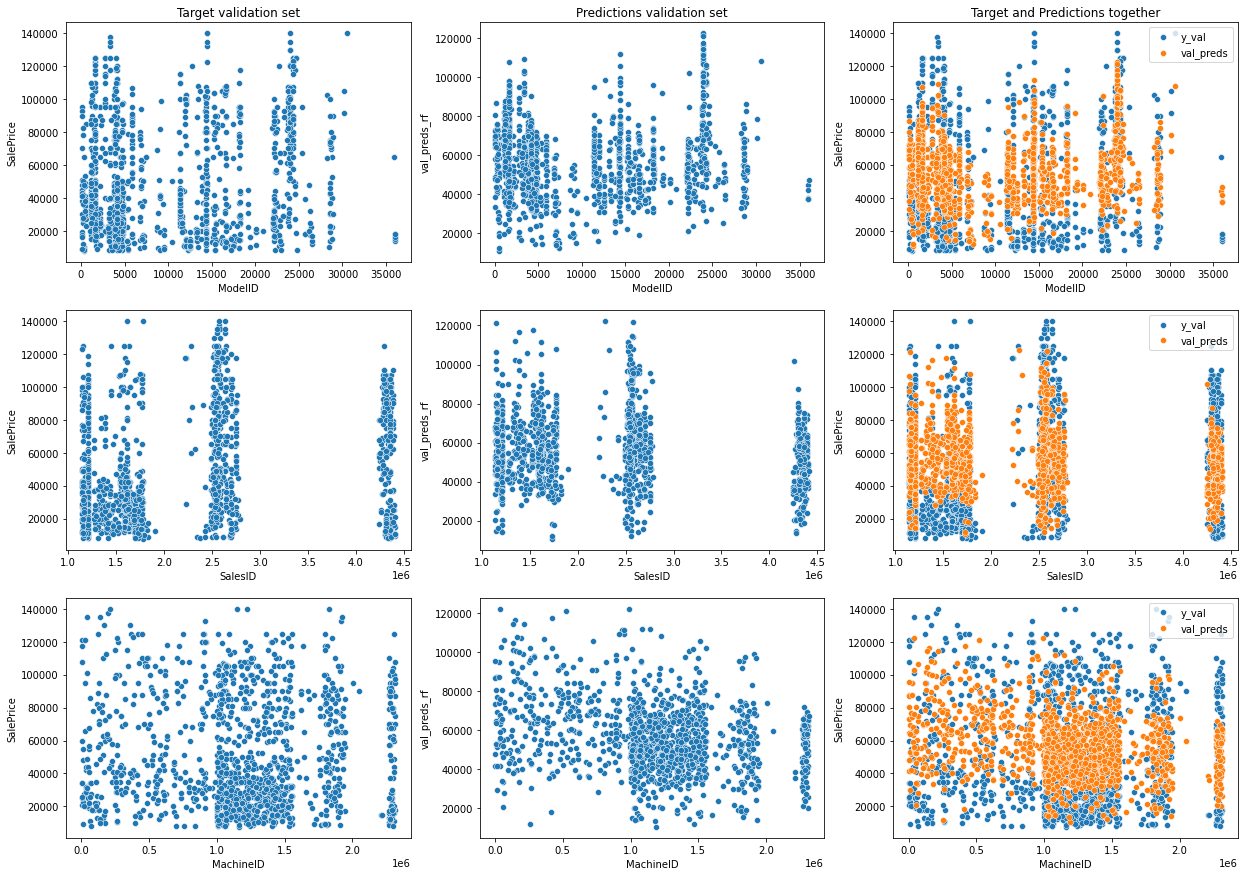

In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(21, 15))
high_error_idx = high_error_idx_rf
val_preds = val_preds_rf
# ModelID
sns.scatterplot(x=X_val_prepared.loc[high_error_idx, "ModelID"], y=y_val.loc[high_error_idx], ax=ax[0,0])
ax[0,0].set_title("Target validation set")
sns.scatterplot(x=X_val_prepared.loc[high_error_idx, "ModelID"], y=val_preds.loc[high_error_idx], ax=ax[0,1])
ax[0,1].set_title("Predictions validation set")
sns.scatterplot(x=X_val_prepared.loc[high_error_idx, "ModelID"], y=y_val.loc[high_error_idx], ax=ax[0,2])
sns.scatterplot(x=X_val_prepared.loc[high_error_idx, "ModelID"], y=val_preds.loc[high_error_idx], ax=ax[0,2])
ax[0,2].legend(["y_val", "val_preds"])
ax[0,2].set_title("Target and Predictions together")

# SalesID
sns.scatterplot(x=X_val_prepared.loc[high_error_idx, "SalesID"], y=y_val.loc[high_error_idx], ax=ax[1,0])
sns.scatterplot(x=X_val_prepared.loc[high_error_idx, "SalesID"], y=val_preds.loc[high_error_idx], ax=ax[1,1])
sns.scatterplot(x=X_val_prepared.loc[high_error_idx, "SalesID"], y=y_val.loc[high_error_idx], ax=ax[1,2])
sns.scatterplot(x=X_val_prepared.loc[high_error_idx, "SalesID"], y=val_preds.loc[high_error_idx], ax=ax[1,2])
ax[1,2].legend(["y_val", "val_preds"])

# MachineID
sns.scatterplot(x=X_val_prepared.loc[high_error_idx, "MachineID"], y=y_val.loc[high_error_idx], ax=ax[2,0])
sns.scatterplot(x=X_val_prepared.loc[high_error_idx, "MachineID"], y=val_preds.loc[high_error_idx], ax=ax[2,1])
sns.scatterplot(x=X_val_prepared.loc[high_error_idx, "MachineID"], y=y_val.loc[high_error_idx], ax=ax[2,2])
sns.scatterplot(x=X_val_prepared.loc[high_error_idx, "MachineID"], y=val_preds.loc[high_error_idx], ax=ax[2,2])
ax[2,2].legend(["y_val", "val_preds"]);

In these plots it's clearly visible that the predictions with high residuals are more conservative, i.e. more to the middle of the price distribution, than the actual target values.

# Exploratory Data Analysis

## Target

Strongly skewed target variable. To get better results we might need to transform it to be more normally distributed. This might make prediction easier.

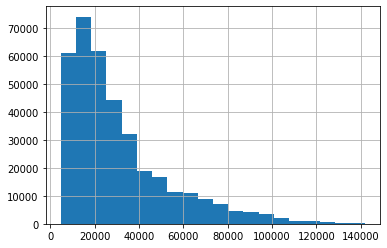

In [12]:
df_train["SalePrice"].hist(bins=20);

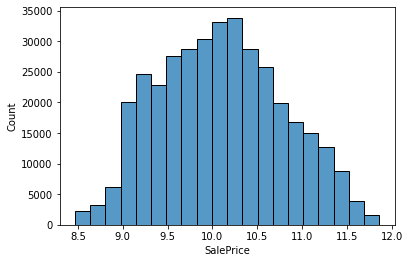

In [13]:
# Log-transformed target variable
sns.histplot(np.log(df_train["SalePrice"]), bins=20);

## Numeric Features

### saleWeek / YearMade / AgeAtSale

In [14]:
# Create saleWeek variable
saleWeek = []
for index, row in df_train["saleDayOfYear"].clip(upper=363).iteritems():
  saleWeek.append(row // 7 + 1)
df_train["saleWeek"] = saleWeek

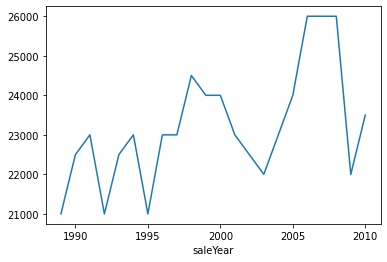

In [15]:
# big dump in SalePrice after financial crisis
df_train.groupby("saleYear")["SalePrice"].median().plot();

In [16]:
# Set all cases to NA where YearMade = 1000
df_train.loc[df_train[df_train["YearMade"]==1000].index, "YearMade"] = np.nan

In [17]:
# Set all cases to NA where the machine was sold earlier than it was built
df_train.loc[df_train[(df_train["YearMade"] > df_train["saleYear"])].index, "YearMade"] = np.nan

In [18]:
# Set all cases to NA where YearMade < 1945 (before end of WWII)
df_train.loc[df_train[df_train["YearMade"]< 1945].index, "YearMade"] = np.nan

In [19]:
# Impute YearMade NAs based on the median of the respective ModelID 
def impute_year_made(df):
  NA_instances = df[df["YearMade"].isna()]["ModelID"].unique()
  for base_model in NA_instances:
    base_model_index = df[(df["ModelID"]==base_model) & (df["YearMade"].isna())].index
    df.loc[base_model_index, "YearMade"] = np.trunc(df[df["ModelID"]==base_model]["YearMade"].median())
  return df

In [20]:
df_train = impute_year_made(df_train)

In [21]:
df_train["YearMade"].isna().sum()

800

In [22]:
df_train["AgeAtSale"] = df_train["saleYear"] - df_train["YearMade"]

In [23]:
# There are some values imputed which lead to negative AgeAtSale values again -> delete them and impute with median
df_train["AgeAtSale"].sort_values().unique()

array([-12., -11.,  -7.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,   2.,   3.,
         4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,  13.,  14.,
        15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,  24.,  25.,
        26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,  36.,
        37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,
        48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,
        61.,  nan])

In [24]:
df_train.loc[df_train[(df_train["YearMade"] > df_train["saleYear"])].index, "YearMade"] = np.nan
df_train["AgeAtSale"] = df_train["saleYear"] - df_train["YearMade"]

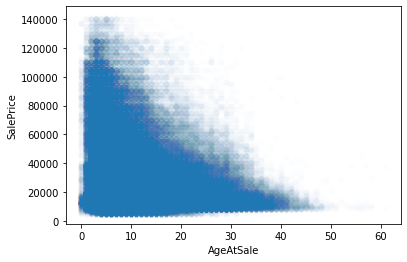

In [25]:
# The older the machine, the lower the price
sns.scatterplot(x="AgeAtSale", y="SalePrice", data=df_train, alpha=0.01);

### ID columns

In [26]:
# Get all ID columns
id_cols = [col for col in df_train.columns if "ID" in col]

In [27]:
df_train[id_cols].nunique()

SalesID         365928
MachineID       313558
ModelID           5040
auctioneerID        30
dtype: int64

* ***SalesID*** = unique identifier of a particular sale of a machine at auction
* ***MachineID*** = identifier for a particular machine (-> machines may have multiple sales)
* ***ModelID*** = identifier for a unique machine model (i.e. fiModelDesc)
* ***auctioneerID*** = identifier of a particular auctioneer (company) that sold the machine at auction

I.e. dataset contains 348k different machines. Which are sold a total of 412k times. These machines consist of 5281 different models and were sold by 30 different auctioneers.

In [28]:
# auctioneerID only feature with NAs
df_train[id_cols].isna().sum()

SalesID             0
MachineID           0
ModelID             0
auctioneerID    20136
dtype: int64

### Other numeric features

In [29]:
# No big difference in SalePrice when grouped by datasource; low cardinality
df_train.groupby("datasource")["SalePrice"].median()

datasource
121    27000.0
132    23000.0
136    26000.0
149    21000.0
172    20000.0
Name: SalePrice, dtype: float64

**MachineHoursCurrentMeter** <br>
current usage of the machine in hours at time of sale (saledate); 
* null or 0 means no hours have been reported for that sale -> not exactly clear whether for both (NA and 0) values are unknown or "no hours reported" means something different in both cases.

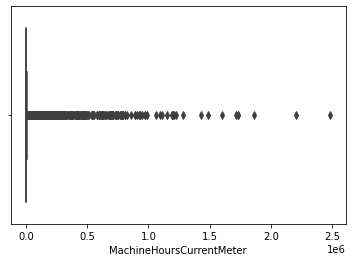

In [30]:
sns.boxplot(x=df_train["MachineHoursCurrentMeter"]);

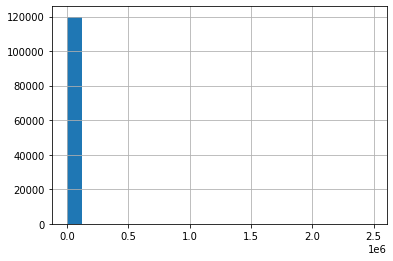

In [31]:
df_train["MachineHoursCurrentMeter"].hist(bins=20);

There are some very high values for MachineHoursCurrentMeter. If we consider that one year has a total of approximately 8760 hours machines with values of over 1 mio. would have been used for more than 114 years nonstop! This is impossible and has to be a mistake. 
* Let's delete all values higher than 200'000 = more than 22 years nonstop use

In [32]:
# Set all cases where MachineHoursCurrentMeter over 200k to NA 
# -> this would mean machine was used nonstop for more than 22 years
df_train.loc[df_train[df_train["MachineHoursCurrentMeter"] > 200_000].index, "MachineHoursCurrentMeter"] = np.nan

In [33]:
# According to the variable info 0 means the same as NA
df_train.loc[df_train[df_train["MachineHoursCurrentMeter"] == 0].index, "MachineHoursCurrentMeter"] = np.nan

Let's create a new column "MaxAgeInHours" which shows the maximum possible hours a machine could have been used accoring to its AgeAtSale. To every AgeAtSale we add 1, because a machine which is made at the first day of a year and sold at the last day of a year would have an AgeAtSale of 0, but could have been used anyway (-> hours higher than 0), and multiply it with 8760 (no. of hours per year).


In [34]:
# Create temporary variable showing the maximum possible hours a machine could have been used at saledate
df_train["MaxAgeInHours"] = (df_train["AgeAtSale"]+1)*8760

In [35]:
# Set all cases where MachineHoursCurrentMeter is bigger than the actually possible max no. of hours to NA
df_train.loc[df_train[df_train["MaxAgeInHours"] < df_train["MachineHoursCurrentMeter"]].index, "MachineHoursCurrentMeter"] = np.nan

# Delete MaxAgeInHours columns, because it perfectly correlates with AgeAtSale
del df_train["MaxAgeInHours"]

In [36]:
# Predicting missing MachineHoursCurrentMeter values based on AgeAtSale column 
df_temp = df_train.copy()
df_temp["AgeAtSale"] = df_temp["AgeAtSale"].fillna(df_temp["AgeAtSale"].median())
df_temp["YearMade"] = df_temp["YearMade"].fillna(df_temp["YearMade"].median())

In [37]:
X = df_temp[df_temp["MachineHoursCurrentMeter"].notnull()]["AgeAtSale"].to_frame()
y = df_temp[df_temp["MachineHoursCurrentMeter"].notnull()]["MachineHoursCurrentMeter"]
X_ = df_temp[df_temp["MachineHoursCurrentMeter"].isna()]["AgeAtSale"].to_frame()

lin_reg = LinearRegression()
lin_reg.fit(X, y)
mhcm_preds = lin_reg.predict(X_)
df_train.loc[df_train[df_train["MachineHoursCurrentMeter"].isna()].index, "MachineHoursCurrentMeter"] = mhcm_preds

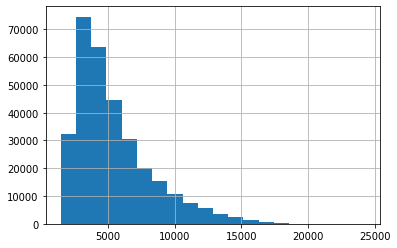

In [38]:
pd.Series(mhcm_preds).hist(bins=20);

## Categorical Features

### fi columns

In [39]:
# fiProductClassDesc is available for every machine -> extract important characteristics, type of machine, numbers (height, power, whatever)
df_train[["fiModelDesc", "fiBaseModel", "fiSecondaryDesc", "fiModelSeries", "fiModelDescriptor", "fiProductClassDesc"]].isna().sum()

fiModelDesc                0
fiBaseModel                0
fiSecondaryDesc       127051
fiModelSeries         314536
fiModelDescriptor     303319
fiProductClassDesc         0
dtype: int64

fiModelDesc makes a difference from fiBaseModel as the saleprices varies a great amount between machines of the same base model. Same goes for fiSecondaryDesc

In [40]:
df_train[["fiModelDesc", "fiBaseModel", "fiSecondaryDesc", "fiModelSeries", "fiModelDescriptor", "fiProductClassDesc"]].nunique()

fiModelDesc           4828
fiBaseModel           1914
fiSecondaryDesc        167
fiModelSeries          115
fiModelDescriptor      136
fiProductClassDesc      74
dtype: int64

### Product Size

* Encode as ordinal feature.From Mini/Compact to Large / Medium.

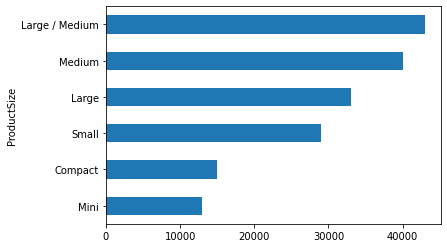

In [41]:
prod_size = df_train.groupby("ProductSize")["SalePrice"].median()
prod_size.sort_values().plot.barh();

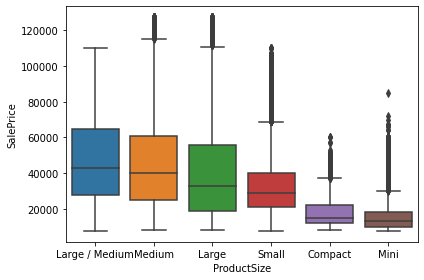

In [42]:
sns.boxplot(x="ProductSize", y="SalePrice", data=df_train, order=prod_size.sort_values(ascending=False).index)
plt.tight_layout();

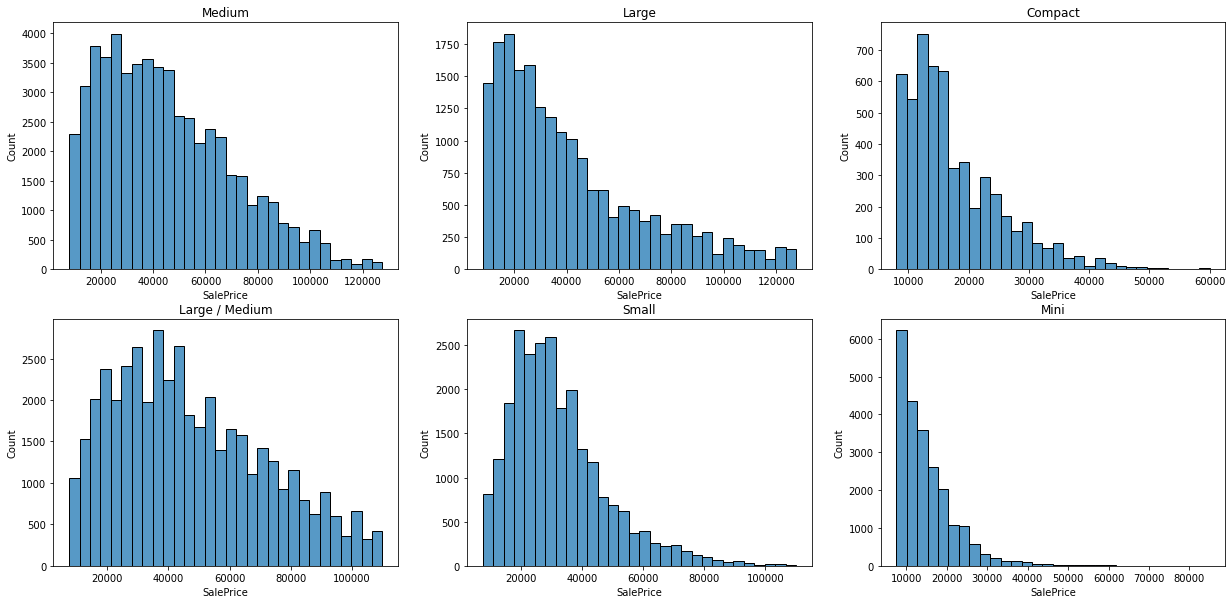

In [43]:
# Histograms for each characteristic of ProductSize
fig, ax = plt.subplots(2, 3, figsize=(21, 10))

for ax, size in zip(ax.flatten(), np.delete(df_train["ProductSize"].unique(), 1)):
  sns.histplot(x=df_train[df_train["ProductSize"] == size]["SalePrice"], bins=30, ax=ax)
  ax.set_title(size)

* Small, Mini and Compact are definitely less expensive on average. 
* Medium, Large/Medium and Large have a less skewed distribution, i.e. more expensive machines. 
* There are much less Large machines than of the other two groups. 
* Large/medium reaches only to app. 100k while the other two go up to 120k. 

### ProductGroup / ProductGroupDesc

In [44]:
# Product Group
df_train.ProductGroup.unique()

array(['TTT', 'WL', 'MG', 'TEX', 'BL', 'SSL'], dtype=object)

In [45]:
# Product Group Description
# -> is the same as Product Group. We can delete Product Group feature
df_train.ProductGroupDesc.unique()

array(['Track Type Tractors', 'Wheel Loader', 'Motor Graders',
       'Track Excavators', 'Backhoe Loaders', 'Skid Steer Loaders'],
      dtype=object)

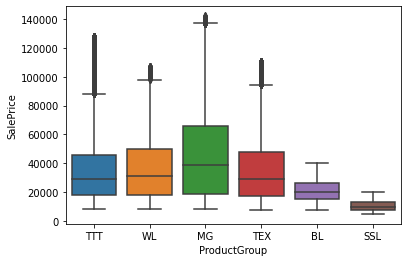

In [46]:
sns.boxplot(x="ProductGroup", y="SalePrice", data=df_train);

In [47]:
# Product Group and ProductGroupDesc provide exactly the same info -> delete one
df_train[["ProductGroup", "ProductGroupDesc"]]

,ProductGroup,ProductGroupDesc
205615,TTT,Track Type Tractors
274835,WL,Wheel Loader
141296,TTT,Track Type Tractors
212552,WL,Wheel Loader
62755,TTT,Track Type Tractors
...,...,...
372370,MG,Motor Graders
363545,WL,Wheel Loader
253898,TEX,Track Excavators
373739,TTT,Track Type Tractors


In [48]:
# Delete ProductGroupDesc
del df_train["ProductGroupDesc"]

### fiProductClassDesc
The first part of the `fiProductClassDesc` feature can be deleted as it's already in `ProductGroupDesc`. However, we can build new features out of the remainings. One for lower boundary of power, one for upper boundary of power and a third one for unit of power (horsepower, metric tons, etc.).

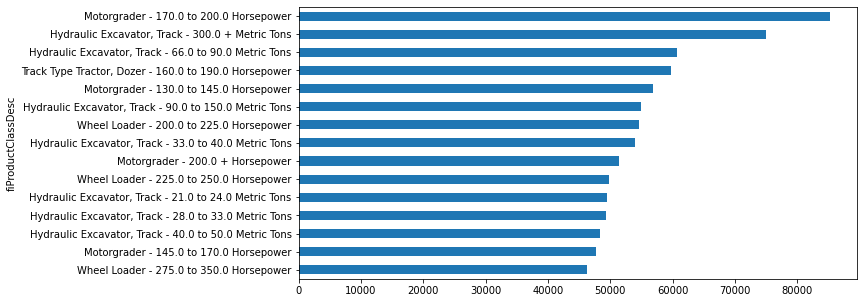

In [49]:
fig, ax = plt.subplots(figsize=(10, 5))
df_train.groupby("fiProductClassDesc")["SalePrice"].mean().sort_values().tail(15).plot.barh();

In [50]:
temp_product = df_train["fiProductClassDesc"].str.split(" - ").str[-1]

In [51]:
temp_product

205615    105.0 to 130.0 Horsepower
274835    120.0 to 135.0 Horsepower
141296    190.0 to 260.0 Horsepower
212552                 Unidentified
62755       20.0 to 75.0 Horsepower
                    ...            
372370    145.0 to 170.0 Horsepower
363545    135.0 to 150.0 Horsepower
253898     19.0 to 21.0 Metric Tons
373739    105.0 to 130.0 Horsepower
20313            260.0 + Horsepower
Name: fiProductClassDesc, Length: 365928, dtype: object

In [52]:
lower = temp_product.str.split(" to ").str[0].str.split(" ").str[0].str.split("+").str[0]
upper_temp = temp_product.str.rsplit(" ").str[2]
upper = upper_temp.replace("Horsepower", np.nan).replace("Ft", np.nan).replace("Construction)", np.nan).replace("Operating", np.nan).replace("Metric", np.nan)
power_unit = temp_product.str.split("0 ").str[-1]
power_unit = power_unit.str.strip("+ ").str.strip("2701.0+ ")

In [53]:
lower = lower.replace("Unidentified", np.nan)
power_unit = power_unit.replace("Unidentified (Compact Construction)", np.nan).replace("Unidentified", np.nan)

In [54]:
lower = lower.astype("float")
upper = upper.astype("float")

df_train["fiProductClassDesc_lower"] = lower
df_train["fiProductClassDesc_upper"] = upper
df_train["fiProductClassDesc_power_unit"] = power_unit

### State

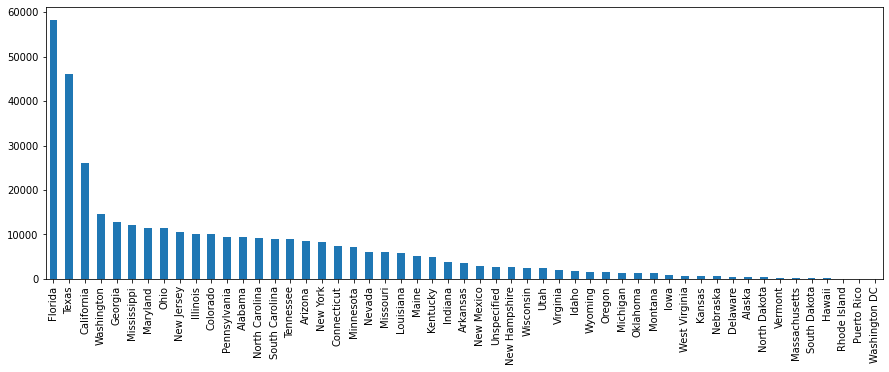

In [55]:
fig, ax = plt.subplots(figsize=(15, 5))
ax = df_train.state.value_counts().plot.bar()

Most of the machines (~ 36% see below) were sold in Florida, Texas and California which are the states with the biggest population. On the other side there are states like Puerto Rico, Sout/North Dakota or Rode Island which have some off the lowest population.

In [56]:
# Percentage of all machines sold
df_train.state.value_counts().sort_values(ascending=False).head(10) / len(df_train)

Florida        0.159179
Texas          0.126276
California     0.071574
Washington     0.039877
Georgia        0.035056
Mississippi    0.033176
Maryland       0.031509
Ohio           0.031473
New Jersey     0.028558
Illinois       0.027863
Name: state, dtype: float64

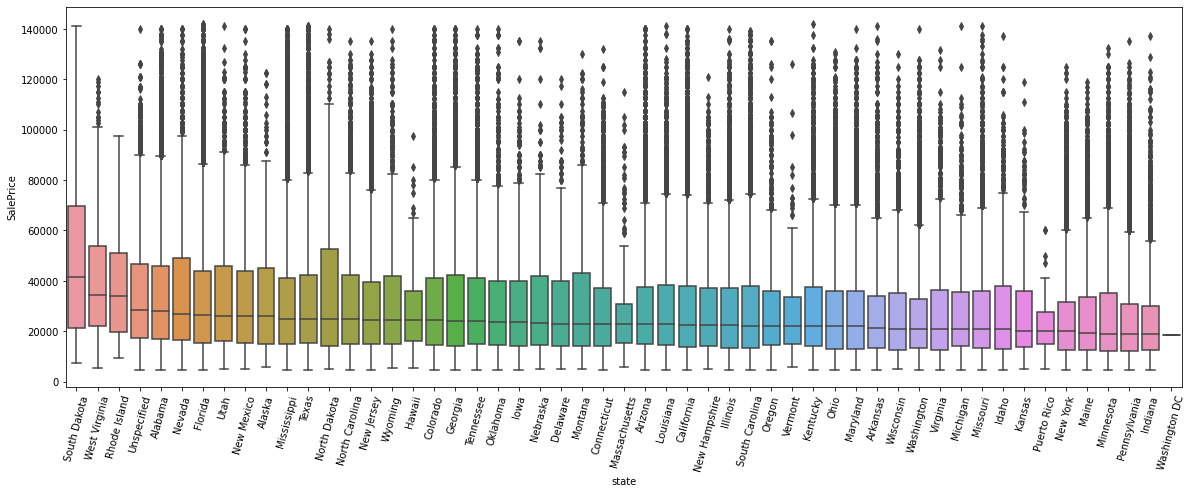

In [57]:
# States seem to have very low influence on the price of the machine
state_ordered = df_train.groupby("state")["SalePrice"].median().sort_values(ascending=False).index
fig, ax = plt.subplots(figsize=(20, 7))
sns.boxplot(x="state", y="SalePrice", data=df_train, order=state_ordered, ax=ax)
plt.xticks(rotation=75);

### Drive System 

Track Type Tractors and Track Excavators don't have any wheels, but tracks. That's why they can't have any "wheel drive". So they go into category "No".

Only Motor Graders and Backhoe Loaders have values for Drive_System!!

In [58]:
df_train["Drive_System"].value_counts()

Two Wheel Drive     42458
Four Wheel Drive    30289
No                  22389
All Wheel Drive       685
Name: Drive_System, dtype: int64

In [59]:
df_train.loc[df_train[df_train["ProductGroup"].isin(["TTT", "TEX"])].index, "Drive_System"] = "No"

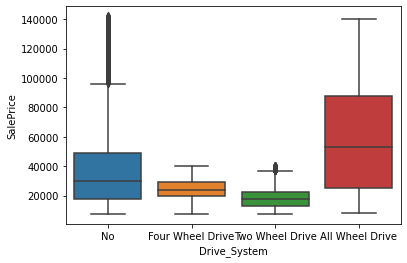

In [60]:
sns.boxplot(x="Drive_System", y="SalePrice", data=df_train);

In [61]:
# Backhoe Loaders approximately evenly distributed between two and four wheel drive 
df_train[(df_train["Drive_System"].notnull()) & (df_train["ProductGroup"]=="BL")]["Drive_System"].value_counts()

Two Wheel Drive     42457
Four Wheel Drive    30289
All Wheel Drive         4
No                      3
Name: Drive_System, dtype: int64

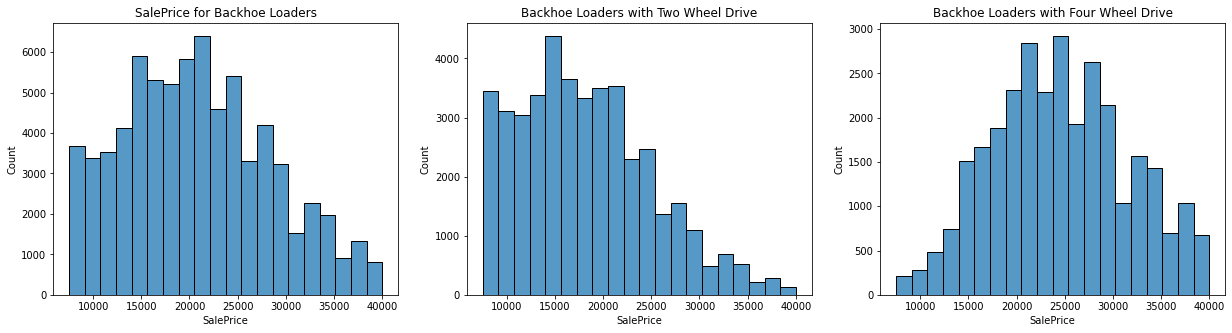

In [62]:
fig, ax = plt.subplots(1, 3, figsize=(21, 5))
sns.histplot(x="SalePrice", data=df_train[df_train["ProductGroup"] == "BL"], bins=20, ax=ax[0])
ax[0].set_title("SalePrice for Backhoe Loaders")
sns.histplot(x="SalePrice", data=df_train[(df_train["ProductGroup"] == "BL")&(df_train["Drive_System"] == "Two Wheel Drive")], bins=20, ax=ax[1])
ax[1].set_title("Backhoe Loaders with Two Wheel Drive")
sns.histplot(x="SalePrice", data=df_train[(df_train["ProductGroup"] == "BL")&(df_train["Drive_System"] == "Four Wheel Drive")], bins=20, ax=ax[2])
ax[2].set_title("Backhoe Loaders with Four Wheel Drive");

Clear difference in distributions betweeen Two Wheel and Four Wheel Drive for Backhoe Loader bulldozers. Also visible in the plot below

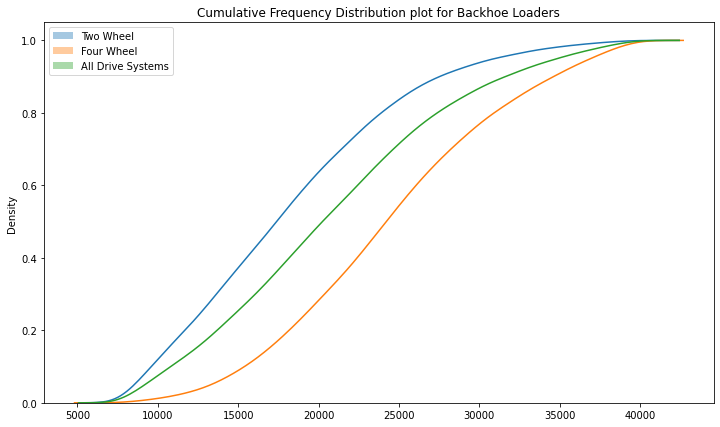

In [63]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.distplot(x=df_train[(df_train["ProductGroup"] == "BL")&(df_train["Drive_System"] == "Two Wheel Drive")]["SalePrice"], kde_kws={"cumulative": True}, ax=ax, label="Two Wheel")
sns.distplot(x=df_train[(df_train["ProductGroup"] == "BL")&(df_train["Drive_System"] == "Four Wheel Drive")]["SalePrice"], kde_kws={"cumulative": True}, ax=ax, label="Four Wheel")
sns.distplot(x=df_train[df_train["ProductGroup"] == "BL"]["SalePrice"], kde_kws={"cumulative": True}, ax=ax, label="All Drive Systems")
ax.legend()
ax.set_title("Cumulative Frequency Distribution plot for Backhoe Loaders");

In [64]:
# No and All Wheels are the most expensive, although the oldest categories
df_train.groupby("Drive_System")[["SalePrice", "AgeAtSale"]].agg(["median", "count"])

SalePrice         AgeAtSale        
                    median   count    median   count
Drive_System                                        
All Wheel Drive    53000.0     685      11.0     681
Four Wheel Drive   24000.0   30289       6.0   30277
No                 30000.0  188086       9.0  187418
Two Wheel Drive    17500.0   42458       8.0   42422

### Enclosure

* For "Enclosure", we see 18 cases for EROPS AC, which seems to be the same as EROPS w AC. -> Take them together
* NO ROPS and None or Unspecified -> set to NA 

ROPS = Rollover Protection System

In [65]:
df_train["Enclosure"].value_counts()

OROPS                  160935
EROPS                  130781
EROPS w AC              73881
EROPS AC                   15
NO ROPS                     3
None or Unspecified         2
Name: Enclosure, dtype: int64

In [66]:
df_train["Enclosure"] = df_train["Enclosure"].replace("EROPS w AC", "EROPS AC")
df_train["Enclosure"] = df_train["Enclosure"].replace("NO ROPS", np.nan).replace("None or Unspecified", np.nan)

In [67]:
df_train["Enclosure"].value_counts() # only 334 NAs

OROPS       160935
EROPS       130781
EROPS AC     73896
Name: Enclosure, dtype: int64

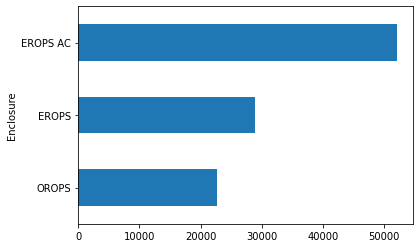

In [68]:
df_train.groupby("Enclosure")["SalePrice"].mean().sort_values().plot.barh();

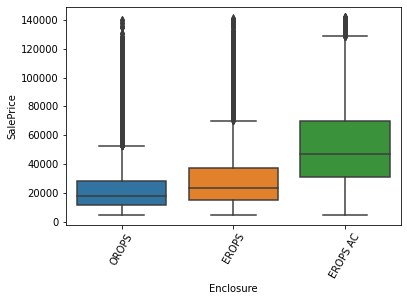

In [69]:
sns.boxplot(x="Enclosure", y="SalePrice", data=df_train)
plt.xticks(rotation=60);

### Ripper

In [70]:
df_train["Ripper"].value_counts()

None or Unspecified    77270
Yes                     7125
Multi Shank             6438
Single Shank            4661
Name: Ripper, dtype: int64

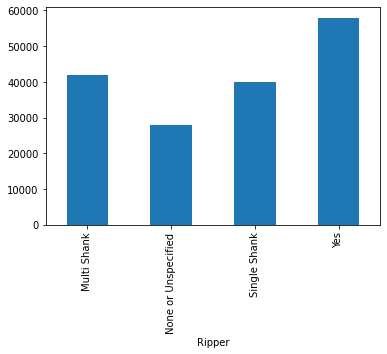

In [71]:
df_train.groupby("Ripper")["SalePrice"].median().plot.bar();

Single or Multi Shank doesn't seem to make a difference. So let's make two categories with Yes and No.

In [72]:
df_train.loc[df_train["Ripper"].isin(["Single Shank", "Multi Shank"]), "Ripper"] = "Yes"

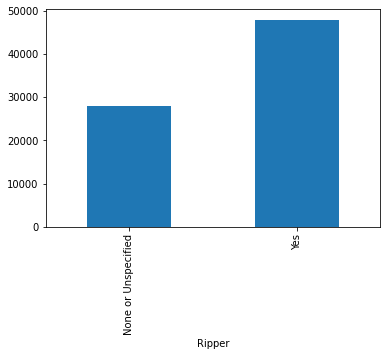

In [73]:
df_train.groupby("Ripper")["SalePrice"].median().plot.bar();

### Remaining categorical features

**Forks**

In [ ]:
df_train["Forks"].value_counts()

None or Unspecified    163463
Yes                     11649
Name: Forks, dtype: int64

In [ ]:
df_train["Forks"].value_counts() / df_train["Forks"].value_counts().sum()

None or Unspecified    0.933477
Yes                    0.066523
Name: Forks, dtype: float64

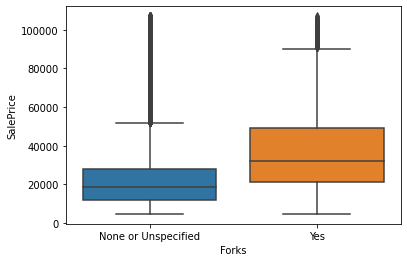

In [ ]:
sns.boxplot(x="Forks", y="SalePrice", data=df_train);

**Pad Type** <br>
There are four different categories from which one means that there are no pads on the bulldozer. The other three categories have a low number of samples. Lets build a new variable with 0 = None and 1 = has some pad type.

In [ ]:
df_train["Pad_Type"].value_counts()

None or Unspecified    64877
Reversible              5344
Street                  2502
Grouser                   23
Name: Pad_Type, dtype: int64

In [ ]:
df_train.groupby("Pad_Type")["SalePrice"].describe()

,count,mean,std,min,25%,50%,75%,max
Pad_Type,,,,,,,,
Grouser,23.0,30218.478261,5561.649411,18500.0,26250.0,31000.0,35000.0,37000.0
None or Unspecified,64877.0,20057.696071,7325.134743,7500.0,14500.0,19500.0,25000.0,40000.0
Reversible,5344.0,27506.090943,6869.202920,7600.0,22500.0,27500.0,33000.0,40000.0
Street,2502.0,25175.179856,7473.006165,7700.0,19500.0,25000.0,31000.0,40000.0


In [ ]:
# Set all != None or Unspecified to 0 (-> gets changed to 1 later on)
df_train.loc[df_train[df_train["Pad_Type"].isin(["Grouser", "Reversible", "Street"])].index, "Pad_Type"] = 1
df_train["Pad_Type"].value_counts()

None or Unspecified    64877
1                       7869
Name: Pad_Type, dtype: int64

**Ride Control**

In [ ]:
# No and None are the same -> take them together
df_train["Ride_Control"].value_counts()

No                     79389
None or Unspecified    64693
Yes                     8646
Name: Ride_Control, dtype: int64

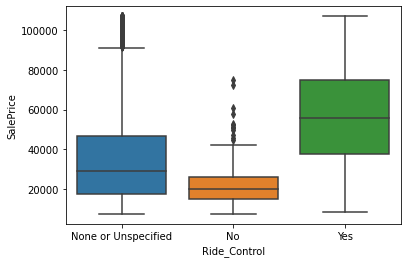

In [ ]:
sns.boxplot(x="Ride_Control", y="SalePrice", data=df_train);

**Transmission**

In [ ]:
df_train["Transmission"].value_counts()

Standard               128983
None or Unspecified     21099
Powershift              10726
Powershuttle             4119
Hydrostatic              2717
Direct Drive              411
Autoshift                  85
AutoShift                  41
Name: Transmission, dtype: int64

In [ ]:
df_train.loc[df_train["Transmission"] == "AutoShift", "Transmission"] = "Autoshift"

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text major ticklabel objects>)

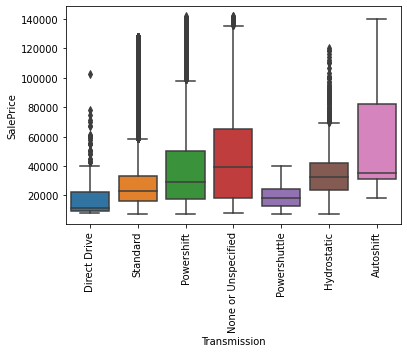

In [ ]:
sns.boxplot(x="Transmission", y="SalePrice", data=df_train)
plt.xticks(rotation=90);

In [ ]:
df_train.groupby("Transmission")["SalePrice"].describe()

,count,mean,std,min,25%,50%,75%,max
Transmission,,,,,,,,
Autoshift,126.0,55349.206349,36360.212862,18000.0,31000.0,35250.0,82500.0,140000.0
Direct Drive,411.0,18083.211679,13727.369773,8000.0,9500.0,11500.0,22500.0,102500.0
Hydrostatic,2717.0,34679.510858,16242.063559,7500.0,24000.0,32500.0,42000.0,120000.0
None or Unspecified,21099.0,46295.597753,32343.865215,8000.0,18000.0,39000.0,65000.0,142000.0
Powershift,10726.0,38003.492541,27807.348405,7500.0,17500.0,29000.0,50000.0,142000.0
Powershuttle,4119.0,19256.735615,7777.750862,7500.0,13000.0,18000.0,24500.0,40000.0
Standard,128983.0,28139.827846,19216.420088,7500.0,16000.0,23000.0,33000.0,127500.0


**Hydraulics / Hydraulics_Flow**

In [ ]:
df_train["Hydraulics"].value_counts()

2 Valve                129764
Standard                97993
Auxiliary               33150
Base + 1 Function       22699
3 Valve                  5159
4 Valve                  2540
Base + 3 Function         265
Base + 2 Function         107
Base + 5 Function          75
Base + 4 Function          63
Base + 6 Function          43
None or Unspecified         9
Name: Hydraulics, dtype: int64

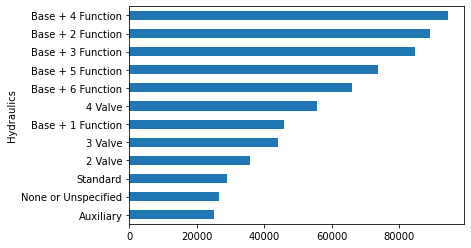

In [ ]:
df_train.groupby("Hydraulics")["SalePrice"].mean().sort_values().plot.barh();

In [ ]:
df_train.groupby("Hydraulics")["SalePrice"].agg(["median", "count"])

,median,count
Hydraulics,,
2 Valve,29000.0,129764
3 Valve,39000.0,5159
4 Valve,50000.0,2540
Auxiliary,16000.0,33150
Base + 1 Function,38000.0,22699
Base + 2 Function,90000.0,107
Base + 3 Function,80000.0,265
Base + 4 Function,92000.0,63
Base + 5 Function,71000.0,75


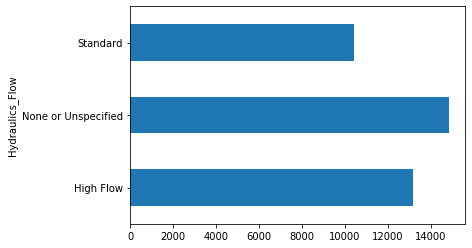

In [ ]:
# Hydraulics_Flow
df_train.groupby(["Hydraulics_Flow"])["SalePrice"].mean().plot.barh();

In [ ]:
df_train[df_train["Hydraulics_Flow"].isna()]["SalePrice"].mean()

33246.619319796926

**Coupler**

In [ ]:
df_train["Coupler"].value_counts()

None or Unspecified    190449
Manual                  23918
Hydraulic                6312
Name: Coupler, dtype: int64

In [ ]:
df_train.groupby("Coupler")["SalePrice"].median()

Coupler
Hydraulic              43000.0
Manual                 27000.0
None or Unspecified    22500.0
Name: SalePrice, dtype: float64

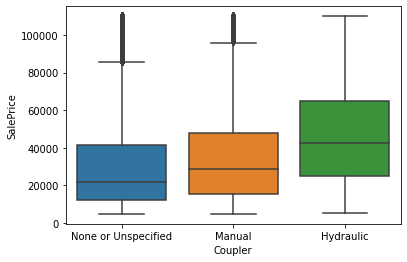

In [ ]:
sns.boxplot(x="Coupler", y="SalePrice", data=df_train);

**Stick**

In [ ]:
df.Stick.value_counts()

Standard    49854
Extended    31242
Name: Stick, dtype: int64

**Turbocharged**

In [ ]:
df_train.Turbocharged.value_counts()

None or Unspecified    77111
Yes                     3985
Name: Turbocharged, dtype: int64

In [ ]:
df_train.groupby("Turbocharged")["SalePrice"].median()

Turbocharged
None or Unspecified    20000.0
Yes                    24000.0
Name: SalePrice, dtype: float64

**Blade_Extension**

Provides no value. Only 577 cases + range from 8k to 142k. -> delete

In [ ]:
df_train.Blade_Extension.value_counts()

None or Unspecified    25406
Yes                      577
Name: Blade_Extension, dtype: int64

In [ ]:
df_train.groupby("Blade_Extension")["SalePrice"].describe()

,count,mean,std,min,25%,50%,75%,max
Blade_Extension,,,,,,,,
None or Unspecified,25406.0,47337.075022,32865.21730,8000.0,19000.0,40000.0,67500.0,142000.0
Yes,577.0,66587.694974,33465.72336,8000.0,41000.0,65000.0,92000.0,142000.0


In [ ]:
del df_train["Blade_Extension"]

**Blade_Width / Blade_Type**

In [ ]:
df_train.Blade_Width.value_counts()

14'                    8739
None or Unspecified    8655
12'                    4423
16'                     867
13'                     297
<12'                     86
Name: Blade_Width, dtype: int64

All values of Blade_Type are from Motor Graders. Does that mean all other types of bulldozers don't have blades?

In [ ]:
df_train.groupby("ProductGroupDesc")["Blade_Width"].value_counts()

ProductGroupDesc  Blade_Width        
Motor Graders     14'                    9867
                  None or Unspecified    9521
                  12'                    5201
                  16'                     960
                  13'                     335
                  <12'                     99
Name: Blade_Width, dtype: int64

In [ ]:
df_train.ProductGroupDesc.value_counts()

Track Excavators       104230
Track Type Tractors     82582
Backhoe Loaders         81401
Wheel Loader            73216
Skid Steer Loaders      45011
Motor Graders           26258
Name: ProductGroupDesc, dtype: int64

Seems not. Blade_Type is (just) available for Track Type Tractors.

In [ ]:
df_train.groupby("ProductGroup")["Blade_Type"].value_counts()

ProductGroup  Blade_Type         
TTT           PAT                    34932
              Straight               12866
              None or Unspecified    10563
              Semi U                  7702
              VPAT                    3099
              U                       1799
              Angle                   1615
              No                       722
              Landfill                  19
              Coal                      10
Name: Blade_Type, dtype: int64

In [ ]:
df_train.Blade_Type.value_counts()

PAT                    39633
Straight               13461
None or Unspecified    11841
Semi U                  8907
VPAT                    3681
U                       1888
Angle                   1684
No                       743
Landfill                  26
Coal                      11
Name: Blade_Type, dtype: int64

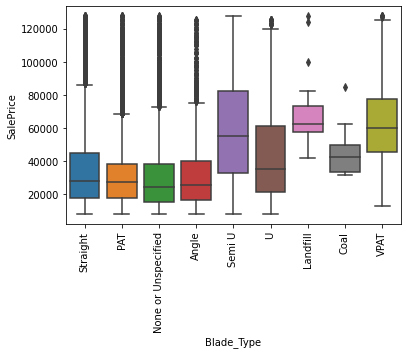

In [ ]:
sns.boxplot(x="Blade_Type", y="SalePrice", data=df_train)
plt.xticks(rotation=90);

**Engine_Horsepower**

In [ ]:
df_train["Engine_Horsepower"].value_counts()

No          24642
Variable     1341
Name: Engine_Horsepower, dtype: int64

In [ ]:
df_train.groupby("Engine_Horsepower")["SalePrice"].describe()

,count,mean,std,min,25%,50%,75%,max
Engine_Horsepower,,,,,,,,
No,24642.0,45452.807321,31833.214326,8000.0,18000.0,38000.0,63000.0,142000.0
Variable,1341.0,90245.152871,24017.720735,28000.0,72500.0,88000.0,106000.0,141000.0


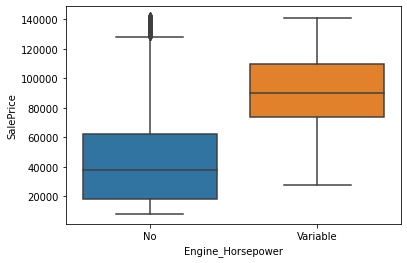

In [ ]:
sns.boxplot(x="Engine_Horsepower", y="SalePrice", data=df_train);

**Undercarriage_Pad_Width**

In [ ]:
df_train["Undercarriage_Pad_Width"].value_counts()

None or Unspecified    82444
32 inch                 5287
28 inch                 3152
24 inch                 2998
20 inch                 2664
30 inch                 1602
36 inch                 1544
18 inch                 1439
34 inch                  540
16 inch                  481
31 inch                  191
27 inch                  144
22 inch                  135
26 inch                   98
33 inch                   94
14 inch                   51
15 inch                   33
25 inch                   17
31.5 inch                  2
Name: Undercarriage_Pad_Width, dtype: int64

**Pattern_Changer**

In [ ]:
df_train["Pattern_Changer"].value_counts()

None or Unspecified    92924
Yes                     9269
No                        68
Name: Pattern_Changer, dtype: int64

In [ ]:
df_train.loc[df_train["Pattern_Changer"] == "No", "Pattern_Changer"] = "None or Unspecified"

In [ ]:
# Engine_Horsepower variable is only for Motor Graders (ProductGroupDesc) non null
df_train["Engine_Horsepower"].value_counts()

No          24642
Variable     1341
Name: Engine_Horsepower, dtype: int64

**UsageBand**

In [ ]:
df_train["UsageBand"].value_counts()

Medium    25159
Low       17691
High       9677
Name: UsageBand, dtype: int64

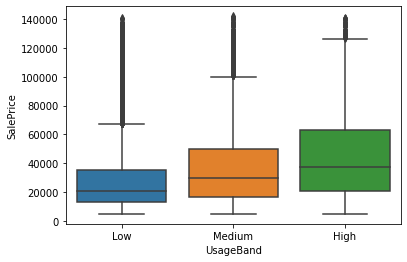

In [ ]:
sns.boxplot(x="UsageBand", y="SalePrice", data=df_train);

In [ ]:
df_train["Enclosure_Type"].value_counts()

None or Unspecified    20342
Low Profile             2088
High Profile             637
Name: Enclosure_Type, dtype: int64

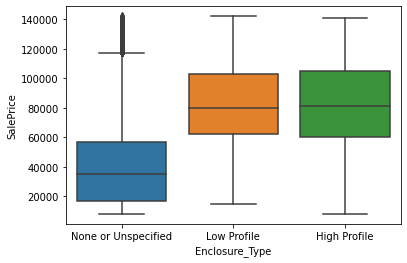

In [ ]:
sns.boxplot(x="Enclosure_Type", y="SalePrice", data=df_train);

# Data Cleaning and Feature Engineering

* In most of the categorical features there are categories like "None or Unspecified", "Unspecified", "None", etc. which are actual missing values. Set them to `np.nan`.
* Tire_Size and Undercarriage_Pad_Width are changed from categorical to numeric variables

**Other Feature Engineering practics I tried**: --> see Appendix
* Time Series Features
  * Add features with moving_averages of the last x weeks/months/years
  * Add time series lag feature (-> e.g. mean price of last day)
* UsageBand (correct the values of UsageBand as they are completely wrong and correct them according to the imputed MachineHoursCurrentMeter values)
* Tire_Size and Stick_Length from nominal to numeric features
* different combinations of ordinal and onehot encoded features
* Add columns which show whether values has been missing before imputation or not (for categoricals only and for all columns)
* Build a new feature with KMeans Clustering and PCA
* Impute/Predict missing values with IterativeImputer
* different imputation techniques:
  * median, mean, 0 for numeric features 
  * most_frequent, 0, -1 for categorical features
  * not imputing anything (leave NAs) in combination with XGBRegressor and LGBMRegressor which can handle NAs
* Log transform target variable

In [74]:
def set_to_na(df):
  """Sets all NA values which are in string format like Unspecified, etc. to actual np.nan"""
  df_copy = df.copy()
  na_cols = ["None or Unspecified", "Unspecified", "#NAME?"]
  for col_idx, cases in enumerate(df_copy.isin(na_cols).sum()):
    if cases > 0:
      for element in na_cols:
        df_copy[df_copy.columns[col_idx]] = df_copy[df_copy.columns[col_idx]].replace(element, np.nan)
  return df_copy

In [75]:
def cat_to_num(df, cols:list):
  """Changes string columns to numerics after stripping "" and "inch" off."""
  for col in cols:
    idx = df[df[col].notnull()].index
    df.loc[idx, col] = df.loc[idx, col].str.rstrip('""').str.rstrip(" inch")
    df[col] = df[col].astype("float")
  return df

In [76]:
def clean_data(df):
  # Set NA values (None or Unspecified, etc.) to NA
  df_new = set_to_na(df)

  # Object columns Tire_Size and Undercarriage_Pad_Width actually represent numeric values
  df_new = cat_to_num(df_new, ["Undercarriage_Pad_Width", "Tire_Size"])

  # Change auctioneerID from numeric to string
  df_new["auctioneerID"] = df_new["auctioneerID"].astype(str)
  df_new.loc[df_new[df_new["auctioneerID"]== "nan"].index, "auctioneerID"] = np.nan

  return df_new

In [77]:
df_new = clean_data(df_train)

# Rapidly iterated Evaluation

The following code served as an iterative evaluation scheme for the different feature engineering techniques and depicts the final version.

In [78]:
# Split data into train and validation set
val_idx = df_new[(df_new["saleYear"]==2010)&(df_new["saleDayOfYear"]>365/2)].index
X_train, y_train = df_new.drop(val_idx).drop("SalePrice", axis=1), df_new.drop(val_idx)["SalePrice"]
X_val, y_val = df_new.loc[val_idx, :].drop("SalePrice", axis=1) ,df_new.loc[val_idx, :]["SalePrice"]

In [79]:
### Ordinal Features
# np.nan on last index, bc NAs have to be imputed anyway & on 1st index it adds 1 to other value's ordinal encodings
product_size_categories = ["Mini", "Compact", "Small", "Medium", "Large / Medium", "Large", np.nan]

### Feature Lists
ordinal_features = ["ProductSize"]
onehot_features = ["Enclosure"]
num_features = X_train.select_dtypes(include=["number"]).columns.tolist()
cat_features = X_train.select_dtypes(exclude=["number"]).columns.tolist()
nominal_features = [col for col in cat_features if col not in [*ordinal_features, *onehot_features]]

### Pipelines and ColumnTransformer
num_pipeline = Pipeline(steps=[("imputer", SimpleImputer(strategy="median"))])
nominal_pipeline = Pipeline(steps=[("nominal", OrdinalEncoder(handle_unknown="use_encoded_value",
                                                     unknown_value=-1))])
ordinal_pipeline = Pipeline(steps=[("ordinal", OrdinalEncoder(categories=[product_size_categories],
                                                              handle_unknown="use_encoded_value",
                                                              unknown_value=-1))])
onehot_pipeline = Pipeline(steps=[("onehot", OneHotEncoder())])

full_pipeline = ColumnTransformer(
    [("num", num_pipeline, num_features),# [col for col in num_features if col not in iterative_num_features]),
     ("nominal", nominal_pipeline, nominal_features),#nominal_features),
     ("ordinal", ordinal_pipeline, ordinal_features),
     ("onehot", onehot_pipeline, onehot_features)
    ])

### Transformations
X_train_prepared = full_pipeline.fit_transform(X_train)
onehot_features_out = full_pipeline.named_transformers_["onehot"][0].get_feature_names_out()
X_train_prepared = pd.DataFrame(X_train_prepared, columns=[*num_features, *nominal_features, *ordinal_features, *onehot_features_out])
X_val_prepared = full_pipeline.transform(X_val)
X_val_prepared = pd.DataFrame(X_val_prepared, columns=[*num_features, *nominal_features, *ordinal_features, *onehot_features_out])

In [80]:
def add_one_fillna(df, features):
  for col in features:
    if df[col].isna().sum():
      df[col] = df[col] + 1
      df[col] = df[col].fillna(0)
  return df

In [81]:
# Add one to all cat columns with NAs and fill NAs with 0
X_train_prepared = add_one_fillna(X_train_prepared, [*num_features, *nominal_features, *ordinal_features, *onehot_features_out])
X_val_prepared = add_one_fillna(X_val_prepared, [*num_features, *nominal_features, *ordinal_features, *onehot_features_out])
y_train, y_val = y_train.reset_index(drop=True), y_val.reset_index(drop=True)

In [82]:
X_train_prepared.shape, X_val_prepared.shape

((351453, 63), (14475, 63))

In [85]:
lgbm_reg = LGBMRegressor()
lgbm_reg.fit(X_train_prepared, y_train)
scores_lgbm, val_preds_lgbm = show_metrics(X_train_prepared, y_train, X_val_prepared, y_val, lgbm_reg)
scores_lgbm

{'Training MAE': 5186.449663090074,
 'Training RMSE': 7842.643406669126,
 'Training R^2': 0.8818701993475322,
 'Valid MAE': 5805.6128811036515,
 'Valid RMSE': 9094.867309812164,
 'Valid R^2': 0.8467644751510858}

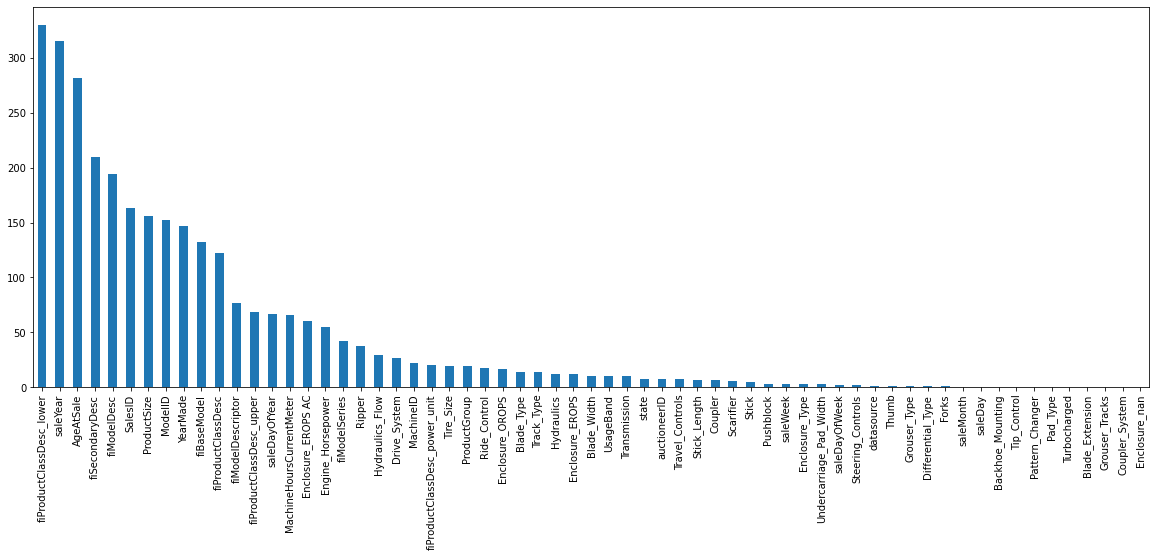

In [87]:
# LGBMRegressor Feature Importances
fig, ax = plt.subplots(figsize=(20, 7))
feature_importances_lgbm = pd.Series(lgbm_reg.feature_importances_, index=X_train_prepared.columns)
ax = feature_importances_lgbm.sort_values(ascending=False).plot.bar()

In [86]:
# Instantiating model
rf_reg = RandomForestRegressor()

# Fit and predict with function from the baseline model section
rf_reg.fit(X_train_prepared, y_train)
scores_rf, val_preds_rf = show_metrics(X_train_prepared, y_train, X_val_prepared, y_val, rf_reg)
scores_rf

{'Training MAE': 1586.0826153994992,
 'Training RMSE': 2579.848280566291,
 'Training R^2': 0.9872172920730277,
 'Valid MAE': 5180.931512953368,
 'Valid RMSE': 8353.58737471112,
 'Valid R^2': 0.8707255303895155}

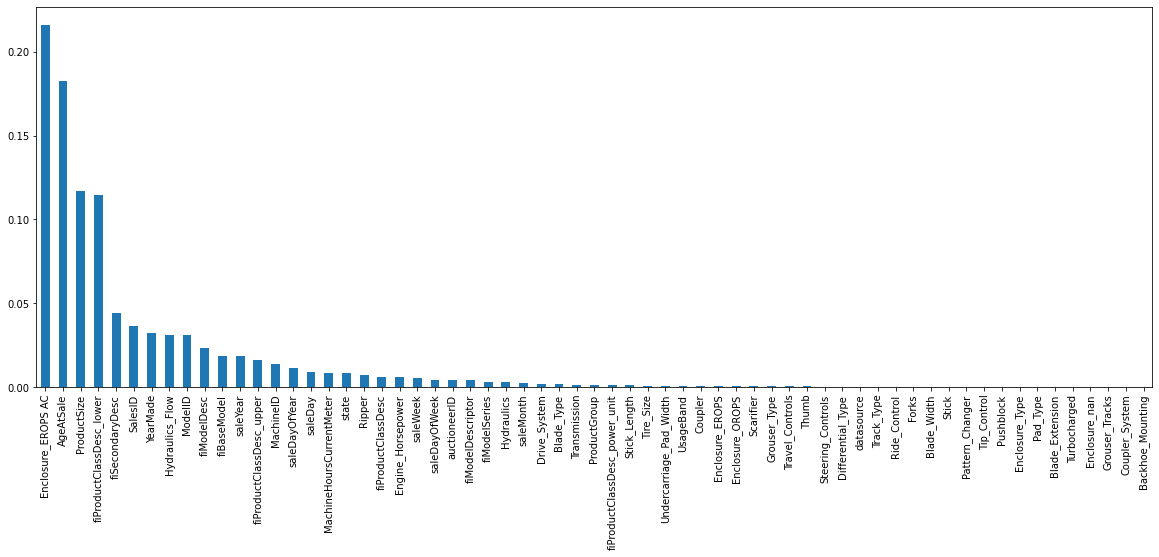

In [88]:
# RandomForest Feature Importances
fig, ax = plt.subplots(figsize=(20, 7))
feature_importances_rf = pd.Series(rf_reg.feature_importances_, index=X_train_prepared.columns)
ax = feature_importances_rf.sort_values(ascending=False).plot.bar()

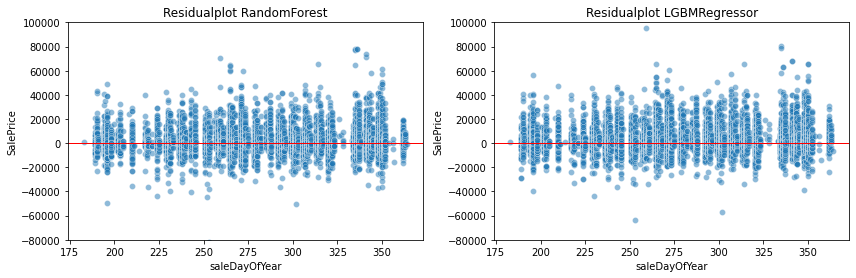

In [91]:
# Residualplots for RandomForest and LGBMRegressor
fig, [ax0, ax1] = plt.subplots(1, 2, figsize=(14, 4))

sns.scatterplot(x=X_val_prepared["saleDayOfYear"], y=y_val - val_preds_rf, alpha=0.5, ax=ax0)
ax0.axhline(0, color="red", linewidth=1)
ax0.set_title("Residualplot RandomForest")
ax0.set_ylim([-80000, 100000])

sns.scatterplot(x=X_val_prepared["saleDayOfYear"], y=y_val - val_preds_lgbm, alpha=0.5, ax=ax1)
ax1.axhline(0, color="red", linewidth=1)
ax1.set_title("Residualplot LGBMRegressor")
ax1.set_ylim([-80000, 100000]);

# Hyperparameter Tuning

**RandomForestRegressor**

In [ ]:
%%time

# Different RandomForestRegressor hyperparameters
param_grid = {
    "n_estimators": [50],
    "max_depth": [30, 35],
    "min_samples_split": np.arange(2, 20, 4),
    "min_samples_leaf": np.arange(2, 5),
    "max_features": [0.4],
    "max_samples": [None]}

# Instantiate RandomizedSearchCV model
rs_model = RandomizedSearchCV(RandomForestRegressor(),
                              param_distributions=param_grid,
                              n_iter=18,
                              cv=5,
                              n_jobs=1,
                              verbose=10)

# Fit the RandomizedSearchCV model
rs_model.fit(X_train_prepared, y_train)

In [ ]:
rs_model.best_estimator_

RandomForestRegressor(max_depth=30, max_features=0.4, min_samples_leaf=2,
                      min_samples_split=10, n_estimators=50)

In [ ]:
rs_model.best_score_

0.8307124552653384

In [92]:
# Instantiate best model
rf_reg = RandomForestRegressor(max_depth=35, max_features=0.4, min_samples_leaf=2,n_estimators=50)

# Fit and predict
rf_reg.fit(X_train_prepared, y_train)
scores_rf, val_preds_rf = show_metrics(X_train_prepared, y_train, X_val_prepared, y_val, rf_reg)
scores_rf

{'Training MAE': 2087.2524461314856,
 'Training RMSE': 3457.6539316528583,
 'Training R^2': 0.9770386414216549,
 'Valid MAE': 5106.162142915313,
 'Valid RMSE': 8167.538532305936,
 'Valid R^2': 0.8764197385418951}

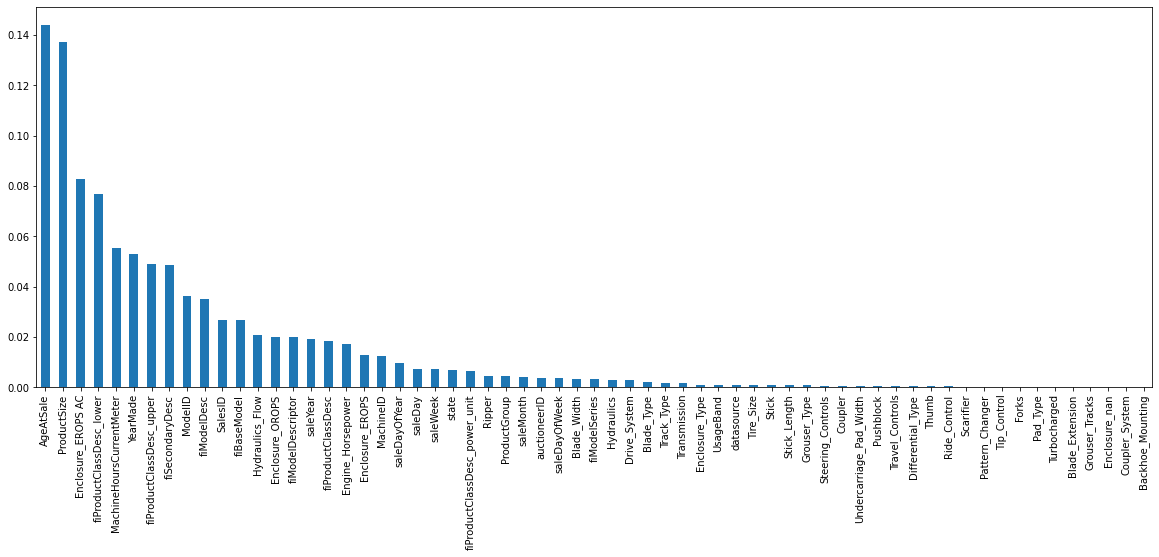

In [ ]:
# RandomForest Feature Importances
fig, ax = plt.subplots(figsize=(20, 7))
feature_importances = pd.Series(rf_reg.feature_importances_, index=X_train_prepared.columns)
ax = feature_importances.sort_values(ascending=False).plot.bar()

**LGBMRegressor**

In [ ]:
param_grid = {
    "num_iterations": [1000, 2000],
    "learning_rate": [0.03, 0.1, 0.2],
    "max_depth": [20],
    "lambda_l2": [0, 1, 2, 5],
    "stopping_rounds": [5, 10, 20],
    "colsample_bytree": [0.4, 0.5, 0.6],
} 

# Instantiate RandomizedSearchCV model
rs_model = RandomizedSearchCV(LGBMRegressor(),
                              param_distributions=param_grid,
                              n_iter=10,
                              cv=5,
                              n_jobs=1,
                              verbose=10)

# Fit the RandomizedSearchCV model
rs_model.fit(X_train_prepared, y_train)

In [94]:
rs_model.best_estimator_

LGBMRegressor(colsample_bytree=0.4, lambda_l2=0, max_depth=20,
              num_iterations=2000, stopping_rounds=10)

In [95]:
rs_model.best_score_

0.8484016741470983

In [96]:
# Instantiate best model
lgbm_reg = LGBMRegressor(colsample_bytree=0.4, lambda_l2=0, max_depth=20, num_iterations=2000, stopping_rounds=10)

# Fit and predict
lgbm_reg.fit(X_train_prepared, y_train)
scores_lgbm, val_preds_lgbm = show_metrics(X_train_prepared, y_train, X_val_prepared, y_val, lgbm_reg)
scores_lgbm

{'Training MAE': 3858.2856445410616,
 'Training RMSE': 5795.446819187803,
 'Training R^2': 0.9354927714484971,
 'Valid MAE': 4985.063714435399,
 'Valid RMSE': 7908.390936149056,
 'Valid R^2': 0.8841374760314099}

# Feature Selection

In [325]:
# Function to check which number of features brings most reasonable results (-> best not always best, because of overfitting)
def feature_selection_mrmr(X_train, y_train, X_val, y_val):
    for num, i in enumerate(range(40, 45)):
        print(num, i)
        print("selecting features...")
        selected_features = mrmr_classif(X_train, y_train, K=i)
        print("fitting model...")
        model = LGBMRegressor(colsample_bytree=0.6, lambda_l2=0, max_depth=20, num_iterations=2000, stopping_rounds=10)
        model.fit(X_train[selected_features], y_train)
        print("making predictions...")
        scores, _ = show_metrics(X_train[selected_features], y_train, X_val[selected_features], y_val, model)
        print(scores)

In [326]:
feature_selection_mrmr(X_train_prepared, y_train, X_val_prepared, y_val)

0 40
selecting features...


100%|██████████| 40/40 [00:31<00:00,  1.29it/s]


fitting model...
making predictions...
{'Training MAE': 4055.8963555702353, 'Valid MAE': 5361.8887060979705, 'Training RMSE': 6088.985114637546, 'Valid RMSE': 8455.57958182862, 'Training R^2': 0.9287927262996643, 'Valid R^2': 0.8675495346840824}
1 41
selecting features...


100%|██████████| 41/41 [00:31<00:00,  1.31it/s]


fitting model...
making predictions...
{'Training MAE': 4071.564965723764, 'Valid MAE': 5302.530834208291, 'Training RMSE': 6109.223247792324, 'Valid RMSE': 8340.072858237934, 'Training R^2': 0.9283185923755682, 'Valid R^2': 0.8711434750754474}
2 42
selecting features...


100%|██████████| 42/42 [00:30<00:00,  1.37it/s]


fitting model...
making predictions...
{'Training MAE': 4065.3724713290603, 'Valid MAE': 5336.654656379556, 'Training RMSE': 6096.8768069800235, 'Valid RMSE': 8371.143304371324, 'Training R^2': 0.9286080288356672, 'Valid R^2': 0.8701815920254659}
3 43
selecting features...


100%|██████████| 43/43 [00:31<00:00,  1.38it/s]


fitting model...
making predictions...
{'Training MAE': 4050.1088294170063, 'Valid MAE': 5286.4620124449975, 'Training RMSE': 6068.510520677198, 'Valid RMSE': 8319.617872388391, 'Training R^2': 0.9292707990100778, 'Valid R^2': 0.8717747707940149}
4 44
selecting features...


100%|██████████| 44/44 [00:31<00:00,  1.38it/s]


fitting model...
making predictions...
{'Training MAE': 4049.243682684746, 'Valid MAE': 5263.810939430857, 'Training RMSE': 6062.563807930034, 'Valid RMSE': 8271.539932150952, 'Training R^2': 0.9294093503588643, 'Valid R^2': 0.8732524810005184}


In [97]:
# Keeping 41 features gave the "best" results
selected_features = mrmr_classif(X_train_prepared, y_train, K=41)

100%|██████████| 41/41 [00:30<00:00,  1.32it/s]


# Test Set Predictions

In [99]:
# Get data ready
# Impute YearMade NAs based on the median of the respective ModelID 
def impute_year_made(df):
  NA_instances = df[df["YearMade"].isna()]["ModelID"].unique()
  for base_model in NA_instances:
    base_model_index = df[(df["ModelID"]==base_model) & (df["YearMade"].isna())].index
    df.loc[base_model_index, "YearMade"] = np.trunc(df[df["ModelID"]==base_model]["YearMade"].median())
  return df

In [100]:
def get_test_set_ready(df):
  df_test = df.copy()
  df_test = clean_data(df_test)

  # Create new saleWeek variable
  saleWeek = []
  for index, row in df_test["saleDayOfYear"].clip(upper=363).iteritems():
    saleWeek.append(row // 7 + 1)
  df_test["saleWeek"] = saleWeek

  # Correct YearMade
  # Set all cases to NA where the machine was sold earlier than it was built
  df_test.loc[df_test[(df_test["YearMade"] > df_test["saleYear"])].index, "YearMade"] = np.nan
  # Set all cases to NA where YearMade < 1945 (before end of WWII)
  df_test.loc[df_test[df_test["YearMade"]< 1945].index, "YearMade"] = np.nan
  # Impute YearMade
  df_train = impute_year_made(df_test)

  # Create AgeAtSale variable
  df_test["AgeAtSale"] = df_test["saleYear"] - df_test["YearMade"]
  df_test.loc[df_test[(df_test["YearMade"] > df_test["saleYear"])].index, "YearMade"] = np.nan
  df_test["AgeAtSale"] = df_test["saleYear"] - df_test["YearMade"]

  # MachineHoursCurrentMeter
  # Set all cases where MachineHoursCurrentMeter over 200k to NA 
  df_test.loc[df_test[df_test["MachineHoursCurrentMeter"] > 200_000].index, "MachineHoursCurrentMeter"] = np.nan
  # According to the variable info 0 means the same as NA
  df_test.loc[df_test[df_test["MachineHoursCurrentMeter"] == 0].index, "MachineHoursCurrentMeter"] = np.nan
  # Create MaxAgeInHours to ckeck for MachineHoursCurrentMeter mistakes
  df_test["MaxAgeInHours"] = (df_test["AgeAtSale"]+1)*8760
  # Set all cases where MachineHoursCurrentMeter is bigger than the actually possible max no. of hours to NA
  df_test.loc[df_test[df_test["MaxAgeInHours"] < df_test["MachineHoursCurrentMeter"]].index, "MachineHoursCurrentMeter"] = np.nan
  del df_test["MaxAgeInHours"]
  # Predicting missing MachineHoursCurrentMeter values based on AgeAtSale column 
  df_temp = df_test.copy()
  df_temp["AgeAtSale"] = df_temp["AgeAtSale"].fillna(df_temp["AgeAtSale"].median())

  df_temp["YearMade"] = df_temp["YearMade"].fillna(df_temp["YearMade"].median())
  X = df_temp[df_temp["MachineHoursCurrentMeter"].notnull()]["AgeAtSale"].to_frame()
  y = df_temp[df_temp["MachineHoursCurrentMeter"].notnull()]["MachineHoursCurrentMeter"]
  X_ = df_temp[df_temp["MachineHoursCurrentMeter"].isna()]["AgeAtSale"].to_frame()

  lin_reg = LinearRegression()
  lin_reg.fit(X, y)
  mhcm_preds = lin_reg.predict(X_)
  df_test.loc[df_test[df_test["MachineHoursCurrentMeter"].isna()].index, "MachineHoursCurrentMeter"] = mhcm_preds

  # Engineer fiProductClassDesc
  temp_product = df_test["fiProductClassDesc"].str.split(" - ").str[-1]

  lower = temp_product.str.split(" to ").str[0].str.split(" ").str[0].str.split("+").str[0]
  upper_temp = temp_product.str.rsplit(" ").str[2]
  upper = upper_temp.replace("Horsepower", np.nan).replace("Ft", np.nan).replace("Construction)", np.nan).replace("Operating", np.nan).replace("Metric", np.nan)
  power_unit = temp_product.str.split("0 ").str[-1]
  power_unit = power_unit.str.strip("+ ").str.strip("2701.0+ ")

  lower = lower.replace("Unidentified", np.nan)
  power_unit = power_unit.replace("Unidentified (Compact Construction)", np.nan).replace("Unidentified", np.nan)
  
  lower = lower.astype("float")
  upper = upper.astype("float")

  df_test["fiProductClassDesc_lower"] = lower
  df_test["fiProductClassDesc_upper"] = upper
  df_test["fiProductClassDesc_power_unit"] = power_unit
  
  # Drive_System
  df_test.loc[df_test[df_test["ProductGroup"].isin(["TTT", "TEX"])].index, "Drive_System"] = "No"

  # Delete ProductGroupcDesc
  del df_test["ProductGroupDesc"]

  # Enclosure
  df_test["Enclosure"] = df_test["Enclosure"].replace("EROPS w AC", "EROPS AC")
  df_test["Enclosure"] = df_test["Enclosure"].replace("NO ROPS", np.nan).replace("None or Unspecified", np.nan)

  # Ripper
  df_test.loc[df_test["Ripper"].isin(["Single Shank", "Multi Shank"]), "Ripper"] = "Yes"

  # Change Backhoe_Mounting from object to float
  df_test["Backhoe_Mounting"] = df_test["Backhoe_Mounting"].astype("object")

  return df_test

In [101]:
df_test_prepared = get_test_set_ready(df_test)

In [102]:
# Get features and target
X_test = df_test_prepared.drop("SalePrice", axis=1)
y_test = df_test_prepared["SalePrice"]

In [103]:
X_test_prepared = full_pipeline.transform(X_test)

In [104]:
X_test_prepared = pd.DataFrame(X_test_prepared, columns=X_train_prepared.columns)
X_test_prepared = add_one_fillna(X_test_prepared, [*num_features, *nominal_features, *ordinal_features, *onehot_features_out])
#X_test_prepared = X_test_prepared[selected_features]
y_test = y_test.reset_index(drop=True)

In [105]:
X_train_total_prepared = pd.concat([X_train_prepared, X_val_prepared], axis=0)
y_train_total = pd.concat([y_train, y_val], axis=0)

In [106]:
X_train_total_prepared.shape, X_test_prepared.shape

((365928, 63), (46770, 63))

In [107]:
def show_metrics(X_train, y_train, X_val, y_val, model):
  train_preds = model.predict(X_train)
  val_preds = model.predict(X_val)
  scores = {"Training MAE": mean_absolute_error(y_train, train_preds),
            "Valid MAE": mean_absolute_error(y_val, val_preds),
            "Training RMSE": mean_squared_error(y_train, train_preds, squared=False),
            "Valid RMSE": mean_squared_error(y_val, val_preds, squared=False),
            "Training R^2": r2_score(y_train, train_preds),
            "Valid R^2": r2_score(y_val, val_preds)}
  return scores, val_preds

In [108]:
# Fit model and get final scores
model = LGBMRegressor(colsample_bytree=0.6, lambda_l2=0, max_depth=20, num_iterations=2000, stopping_rounds=10)
model.fit(X_train_total_prepared[selected_features], y_train_total)
scores_test, test_preds = show_metrics(X_train_total_prepared[selected_features], y_train_total, X_test_prepared[selected_features], y_test, model)

In [109]:
scores_test

{'Training MAE': 4065.562998112662,
 'Training RMSE': 6101.438032192967,
 'Training R^2': 0.9286059553257667,
 'Valid MAE': 6460.723016846923,
 'Valid RMSE': 10036.140410921462,
 'Valid R^2': 0.8415473019787401}

# Interpretation of Model and Test Scores
* Rather small validation set in comparison to a bigger test set


In [110]:
print("Number of validation samples: ", X_val_prepared.shape[0])
print("Number of test samples: ", X_test_prepared.shape[0])

Number of validation samples:  14475
Number of test samples:  46770


* Steep average price increase hasn't been accurately taken into account by the model
  * Validation set reached to the red line. Test set to the right of the red line.

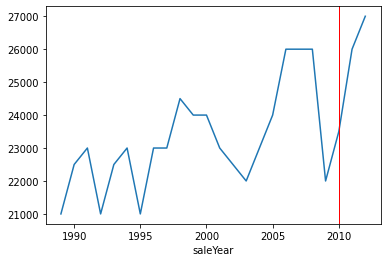

In [111]:
df.groupby("saleYear")["SalePrice"].median().plot()
plt.axvline([2010], color="red", linewidth=1);

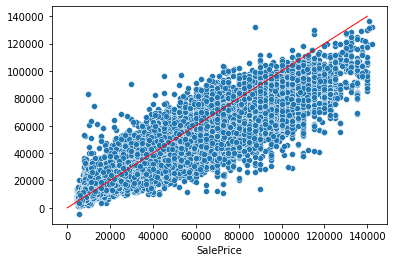

In [112]:
# Analaysis of Restults
sns.scatterplot(x=y_test, y=test_preds)
sns.lineplot([0, 140000], [0, 140000], color="red", linewidth=1);

This uncapability of taking the increasing price into account is clearly visible in this plot. The higher the price of the machine the more tends the model to underestimate it.

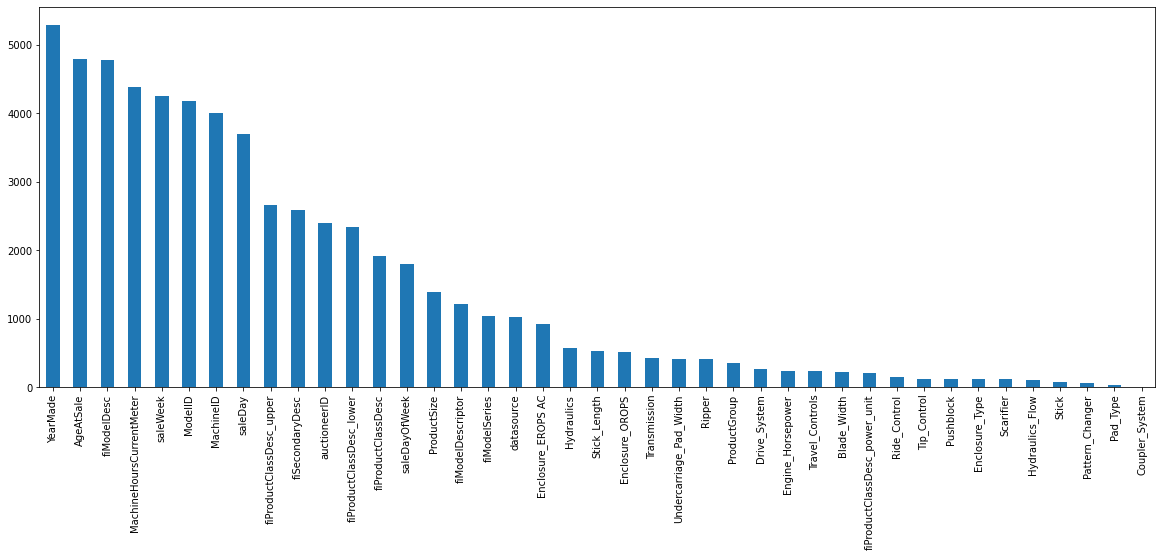

In [113]:
fig, ax = plt.subplots(figsize=(20, 7))
feature_importances = pd.Series(model.feature_importances_, index=X_train_total_prepared[selected_features].columns)
ax = feature_importances.sort_values(ascending=False).plot.bar()

The predictions of the final model are on average 10'036 Dollar off. Furthermore, it's able to explain ~84% of the variation of the prices in the set set.

# Appendix

Contains some of the aformentioned feature engineering techniques that were tried, but didn't improve the validation results.

### KMeans

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

minmax = MinMaxScaler()
X_train_prepared = pd.DataFrame(minmax.fit_transform(X_train_prepared), columns=X_train_prepared.columns)
X_val_prepared = pd.DataFrame(minmax.transform(X_val_prepared), columns=X_val_prepared.columns)

In [ ]:
sum_of_squared_distances = []
K = range(1, 101, 10)
for num, num_clusters in enumerate(K):
  print(num)
  kmeans = KMeans(n_clusters=num_clusters)
  kmeans.fit(X_train_prepared)
  sum_of_squared_distances.append(kmeans.inertia_)

0
1
2
3
4
5
6
7
8
9


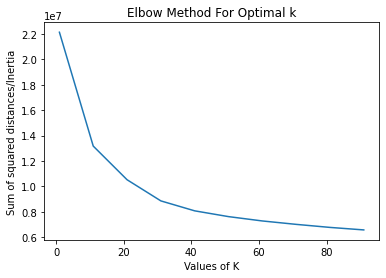

In [ ]:
plt.plot(K, Sum_of_squared_distances)
plt.xlabel("Values of K") 
plt.ylabel("Sum of squared distances/Inertia") 
plt.title("Elbow Method For Optimal k");

In [ ]:
X_train_prepared.shape, X_val_prepared.shape

((351453, 64), (14475, 64))

In [ ]:
kmeans = KMeans(n_clusters=30)
kmeans.fit(X_train_prepared)

In [ ]:
kmeans_feature_train = kmeans.labels_
kmeans_feature_val = kmeans.predict(X_val_prepared)
X_train_prepared["kmeans_feature"] = kmeans_feature_train
X_val_prepared["kmeans_feature"] = kmeans_feature_val

### Time Series Features

In [1]:
#!pip install statsmodels --upgrade
from statsmodels.tsa.deterministic import DeterministicProcess 

In [114]:
# Get time_dummy
def get_time_dummy(df, time_unit):
  time_dummy = []
  if time_unit == "year":
    time_dummy = df.groupby(["saleYear"])["SalePrice"].median().index
    median_saleprice_per_unit = df.groupby("saleYear")["SalePrice"].mean().values
  elif time_unit == "month":
    time_dummy_index = df.groupby(["saleYear", "saleMonth"])["SalePrice"].mean().index
    median_saleprice_per_unit = df.groupby(["saleYear", "saleMonth"])["SalePrice"].mean().values
    for num, (year, day) in enumerate(time_dummy_index):
      time_dummy.append( (year-1989)*12 + day )
  elif time_unit == "week":
    time_dummy_index = df.groupby(["saleYear", "saleWeek"])["SalePrice"].mean().index
    median_saleprice_per_unit = df.groupby(["saleYear", "saleWeek"])["SalePrice"].mean().values
    for num, (year, day) in enumerate(time_dummy_index):
      time_dummy.append( (year-1989)*52 + day )
  elif time_unit == "day":
    time_dummy_index = df.groupby(["saleYear", "saleDayOfYear"])["SalePrice"].mean().index
    median_saleprice_per_unit = df.groupby(["saleYear", "saleDayOfYear"])["SalePrice"].mean().values
    for num, (year, day) in enumerate(time_dummy_index):
      time_dummy.append( (year-1989)*365 + day )
  return time_dummy, median_saleprice_per_unit

In [115]:
# Create new saleWeek variable
saleWeek = []
for index, row in df["saleDayOfYear"].clip(upper=363).iteritems():
  saleWeek.append(row // 7 + 1)
df["saleWeek"] = saleWeek

In [116]:
time_dummy, median_saleprice_per_week = get_time_dummy(df, "week")

In [117]:
len(time_dummy), len(median_saleprice_per_week)

(1129, 1129)

In [118]:
dp = DeterministicProcess(index=time_dummy, constant=True, order=3)
X = dp.in_sample()
X_fore = dp.out_of_sample(70)
X_fore.index = list(range(X.index.max()+1, X.index.max()+len(X_fore)+1))

In [119]:
from sklearn.linear_model import LinearRegression

model = LinearRegression(fit_intercept=False) # is already in X (=constant)
model.fit(X, median_saleprice_per_week)

y_pred = pd.Series(model.predict(X), index=time_dummy)

In [120]:
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

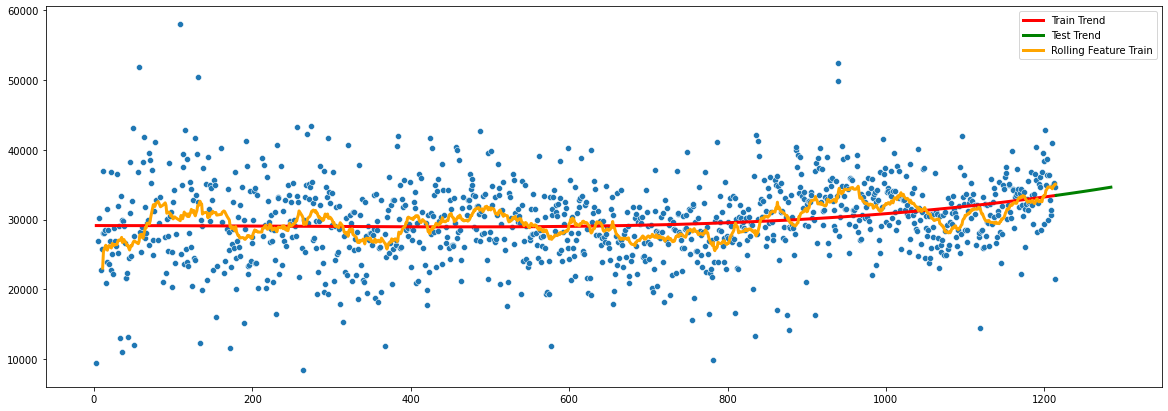

In [124]:
fix, ax = plt.subplots(figsize=(20, 7))
sns.scatterplot(x=time_dummy, y=median_saleprice_per_week)
moving_average = pd.Series(median_saleprice_per_week).rolling(window=26, center=False, min_periods=5, closed="left").mean()
sns.lineplot(x=X.index, y=y_pred, color="red", linewidth=3)
sns.lineplot(x=X_fore.index, y=y_fore, color="green", linewidth=3)
sns.lineplot(x=time_dummy, y=moving_average, color="orange", linewidth=3)
plt.legend(["Train Trend", "Test Trend", "Rolling Feature Train"]);

In [51]:
def add_moving_average(df, moving_average, time_unit):
  for num, (year, week) in enumerate(df.groupby(["saleYear", time_unit])["SalePrice"].count().index):
    df.loc[df[(df["saleYear"]==year) & (df[time_unit]==week)].index, "moving_average_"+time_unit] = moving_average[num]
  return df

In [52]:
df_train = add_moving_average(df_train, moving_average, "saleWeek")

In [ ]:
1# Creating one year lagged variable of target
lag_1 = pd.Series(median_saleprice_per_week).shift(1) # shift creates lagged variable with 1-lag

In [ ]:
df_train = add_moving_average(df_train, lag_1, "saleWeek")

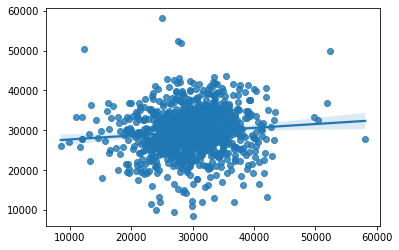

In [ ]:
# nice relationship between median prices per year and the lagged variable 
sns.regplot(median_saleprice_per_week, lag_1);

### UsageBand
-> how many hours the machines were used in comparison to all the other machines from the same fiBaseModel

**Classification for UsageBand:**
* if MachineHoursCurrentMeter for fiBaseModel lie below (6/10) * mean => "Low"
* if MachineHoursCurrentMeter for fiBaseModel lie between (6/10) * mean and (14/10) * mean => "Medium"
* if MachineHoursCurrentMeter for fiBaseModel lie above (14/10) * mean => "High"

In [ ]:
# Get the mean hours used per base model
mhcm_mean_per_fiBaseModel = df_train.groupby("fiBaseModel")["MachineHoursCurrentMeter"].mean().to_dict()

In [ ]:
# Map the mean hours onto every base model to create a new feature
df_train["mhcm_mean_per_fiBaseModel"] = df_train["fiBaseModel"].map(mhcm_mean_per_fiBaseModel)

In [ ]:
# Update UsageBand with new values
UsageBand = np.where(df_train["MachineHoursCurrentMeter"] <= (6/10)*df_train["mhcm_mean_per_fiBaseModel"], "Low",
                     np.where((df_train["MachineHoursCurrentMeter"] > (6/10)*df_train["mhcm_mean_per_fiBaseModel"]) & (df_train["MachineHoursCurrentMeter"] < (14/10)*df_train["mhcm_mean_per_fiBaseModel"]), "Medium",
                              np.where(df_train["MachineHoursCurrentMeter"] > (14/10) * df_train["mhcm_mean_per_fiBaseModel"], "High", 0)))

### Tire_Size

In [ ]:
df_train["Tire_Size"].value_counts()

None or Unspecified    42882
20.5                   13632
14"                     7912
23.5                    7608
26.5                    3997
17.5                    3705
29.5                    2464
17.5"                   1655
13"                      707
20.5"                    666
15.5                     587
15.5"                    425
23.5"                    277
7.0"                      49
23.1"                     18
10"                        6
10 inch                    3
Name: Tire_Size, dtype: int64

In [ ]:
a = df_train["Tire_Size"]

In [ ]:
# Strip off inch signs and keyword
df_train["Tire_Size"] = df_train["Tire_Size"].str.rstrip('"').str.replace(" inch", "")

### Stick_Length

In [ ]:
df_train["Stick_Length"].value_counts()

None or Unspecified    71584
9' 6"                   5266
10' 6"                  3064
11' 0"                  1445
9' 10"                  1311
9' 8"                   1229
9' 7"                   1215
12' 10"                  929
10' 2"                   883
8' 6"                    835
8' 2"                    561
10' 10"                  356
11' 10"                  269
12' 8"                   261
8' 4"                    257
8' 10"                    97
9' 5"                     89
15' 9"                    80
12' 4"                    71
6' 3"                     40
13' 9"                     7
14' 1"                     5
13' 10"                    5
7' 10"                     3
13' 7"                     3
24' 3"                     2
9' 2"                      1
19' 8"                     1
15' 4"                     1
Name: Stick_Length, dtype: int64

In [ ]:
def clean_stick_length(series):
    feet = []
    inch = []
    if pd.notnull(series):
        if series == "None or Unspecified":
          return "None or Unspecified"
        if series != "None or Unspecified":
            for i in series.split():
                if "'" in i:
                    feet.append(int(i.strip("'")))
                elif '"' in i:
                    inch.append(int(i.strip('"')))
            inch_updated = (feet[0] * 3) + inch[0]
            return inch_updated
    elif pd.isnull(series):
        return series

In [ ]:
df_train["Stick_Length"] = df_train["Stick_Length"].apply(clean_stick_length)